In [42]:
import pandas as pd
import numpy as np
from ete3 import Tree
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
import csv
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Root NC_001806 as outgroup of dice distance tree

Herpesviricetes shares the same realm as class Caudoviricetes - Duplodnaviria. Use it as outgroup to root tree for phylorank RED normalization.

In [46]:
# Optimal % shared dice dist tree
tree = Tree("../data/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ.nwk")
outgroup_node = tree&"NC_001806"
tree.set_outgroup(outgroup_node)
print("Outgroup set to:", outgroup_node.name)
tree.write(outfile="../data/phylorank/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ_rooted.nwk")

Outgroup set to: NC_001806


# 2. Create phylorank annotation file

In [3]:
ictv_metadata_4083 = pd.read_csv('../data/4083_ICTV_metadata.csv')

In [6]:
ictv_metadata_4083['Domain'] = 'Virus'
ictv = ictv_metadata_4083
ictv.fillna('', inplace=True)
ictv['taxonomy_string'] = (
    ictv['Virus REFSEQ accession'] + '\t' +
    'd__' + ictv['Domain'] + ';' +
    'p__' + ictv['Phylum'] + ';' +
    'c__' + ictv['Class'] + ';' +
    'o__' + ictv['Order'] + ';' +
    'f__' + ictv['Family'] + ';' +
    'g__' + ictv['Genus'] + ';' +
    's__' + ictv['Species']
)
ictv['taxonomy_string'].to_csv('../data/phylorank/phylorank_annotation.txt', sep='\t', index=False, header=False)

#run phylorank..
#phylorank outliers --fixed_root -t phylorank_annotation.txt --verbose_table 4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ_rooted.nwk phylorank_annotation.txt phylorank_out

# 3. Import MRCA RED values (phylorank output) to determine taxa rank thresholds

In [4]:
# Phylorank generated RED scaled tree
tree = Tree("../data/phylorank/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ_rooted.scaled.tree")

In [5]:
REDs = pd.read_csv('../data/phylorank/4084_dice_cov5_c0.4_tm0.3_re1_e1e-2_NJ_rooted.node_rd.tsv',
                   header=None, sep='\t',
                   names=["Node", "RED"])

In [6]:
REDs.head()

,Node,RED
0,NC_001806|NC_048830,0.000000
1,NC_001806,1.000000
2,BK063678|NC_048830,0.262356
3,BK063678|NC_001902,0.235472
4,BK063678|NC_062738,0.312629


In [7]:
metadata = ictv_metadata_4083.rename(columns={"genome_accn": "Leaf"})

In [8]:
metadata.shape

(4083, 37)

In [9]:
# exclude outgroup for ami calculation
metadata = metadata[metadata.Leaf!='NC_001806']

In [10]:
metadata.shape

(4082, 37)

# 3.1 Annotate tree nodes with RED score

In [11]:
for _, row in tqdm(REDs.iterrows(), total=len(REDs), desc="Processing REDs"):    
    # Split pair into two leaves
    pair = row["Node"].split("|")
    if len(pair) != 2:
        continue  # Skip invalid entries
    leaf1, leaf2 = pair
    red_value = row["RED"]
    mrca_label = '_'.join([leaf1, leaf2, str(red_value)])
    # Find MRCA of the two leaves
    try:
        mrca = tree.get_common_ancestor(leaf1, leaf2)
        mrca.name = mrca_label
        mrca.add_feature("RED", red_value)
    except:
        continue  # Continue if one of the leaves is not in the tree

Processing REDs: 100%|████████████████████████████████████████████████████████████| 8165/8165 [00:12<00:00, 651.51it/s]


# 3.2 Refining taxonomic assignments and classifying unassigned taxa using RED and AMI scores

In [12]:
from sklearn.metrics import adjusted_mutual_info_score

In [13]:
def calculate_ami(true_labels, pred_labels):
    # Assuming true_labels and pred_labels are lists of corresponding labels for each tip
    return adjusted_mutual_info_score(true_labels, pred_labels, average_method='arithmetic')

In [14]:
missing_values = ['', 'Unknown', 'Unclassified']
for col in ['Order', 'Family', 'Subfamily', 'Genus', 'Species']:
    metadata[col] = metadata[col].replace(missing_values, np.nan)

In [15]:
metadata_family = metadata.dropna(subset=['Family'])
metadata_order = metadata.dropna(subset=['Order'])
metadata_subfamily = metadata.dropna(subset=['Subfamily'])
metadata_genus = metadata.dropna(subset=['Genus'])
metadata_species = metadata.dropna(subset=['Species'])

In [16]:
def calculate_ami(tree, red_values, metadata, taxa_column):
    """
    Calculate AMI values by cutting the tree at different RED thresholds and count unique taxa in each cluster.

    Args:
    - tree: A tree object with a 'RED' attribute for each node.
    - red_values: List of RED cutoffs (e.g., np.arange(0, 1, 0.01)).
    - metadata: A pandas DataFrame containing ICTV labels and tip names.
    - taxa_column: The column in metadata representing ICTV classifications.

    Returns:
    - A pandas DataFrame with RED values, AMI scores, cluster statistics.
    """
    ami_results = []

    # Iterate over RED cutoffs
    for i, red in enumerate(tqdm(red_values, desc="Processing RED cutoffs")):
        clusters = []

        # Traverse the tree and cut at the given RED value
        for node in tree.traverse("preorder"):
            if hasattr(node, "RED") and float(node.RED) <= red:
                cluster = node.get_leaf_names()
                clusters.append(cluster)

        # Assign cluster IDs to leaves
        tip_to_cluster = {}
        for cluster_id, cluster in enumerate(clusters):
            for tip in cluster:
                tip_to_cluster[tip] = cluster_id

        # Filter metadata to include only tips in the tree
        labeled_metadata = metadata[metadata["Leaf"].isin(tip_to_cluster.keys())].copy()
        
        if labeled_metadata.empty:
            continue
        
        # Assign cluster IDs to labeled metadata
        labeled_metadata["Cluster"] = labeled_metadata["Leaf"].map(tip_to_cluster)

        # Compute AMI score
        true_labels = labeled_metadata[taxa_column].values
        predicted_clusters = labeled_metadata["Cluster"].values
        ami_score = adjusted_mutual_info_score(true_labels, predicted_clusters)

        # Group by cluster and compute statistics
        cluster_stats = labeled_metadata.groupby("Cluster").agg(
            Num_Leaves=("Leaf", "count"),  # Number of leaves in each cluster
            Unique_Taxa=(taxa_column, "nunique")  # Unique count of given taxonomic rank
        )

        # Compute max & total values
        max_leaves = cluster_stats["Num_Leaves"].max()
        max_unique_taxa = cluster_stats["Unique_Taxa"].max()
        num_clusters = cluster_stats.shape[0]  # Total number of clusters

        # Store in results
        ami_results.append((red, ami_score, max_leaves, max_unique_taxa, num_clusters))

    # Convert results to DataFrame
    ami_df = pd.DataFrame(ami_results, columns=["RED", "AMI", "Max Leaves in Cluster", f"Max Unique {taxa_column} Count", "Total Clusters"])

    return ami_df

In [17]:
red_values = np.arange(0, 1, 0.01)  # RED values from 0 to 1 in steps of 0.01
order_ami_df = calculate_ami(tree, red_values, metadata_order, taxa_column="Order")
family_ami_df = calculate_ami(tree, red_values, metadata_family, taxa_column="Family")
subfamily_ami_df = calculate_ami(tree, red_values, metadata_subfamily, taxa_column="Subfamily")
genus_ami_df = calculate_ami(tree, red_values, metadata_genus, taxa_column="Genus")
species_ami_df = calculate_ami(tree, red_values, metadata_species, taxa_column="Species")

Processing RED cutoffs: 100%|████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


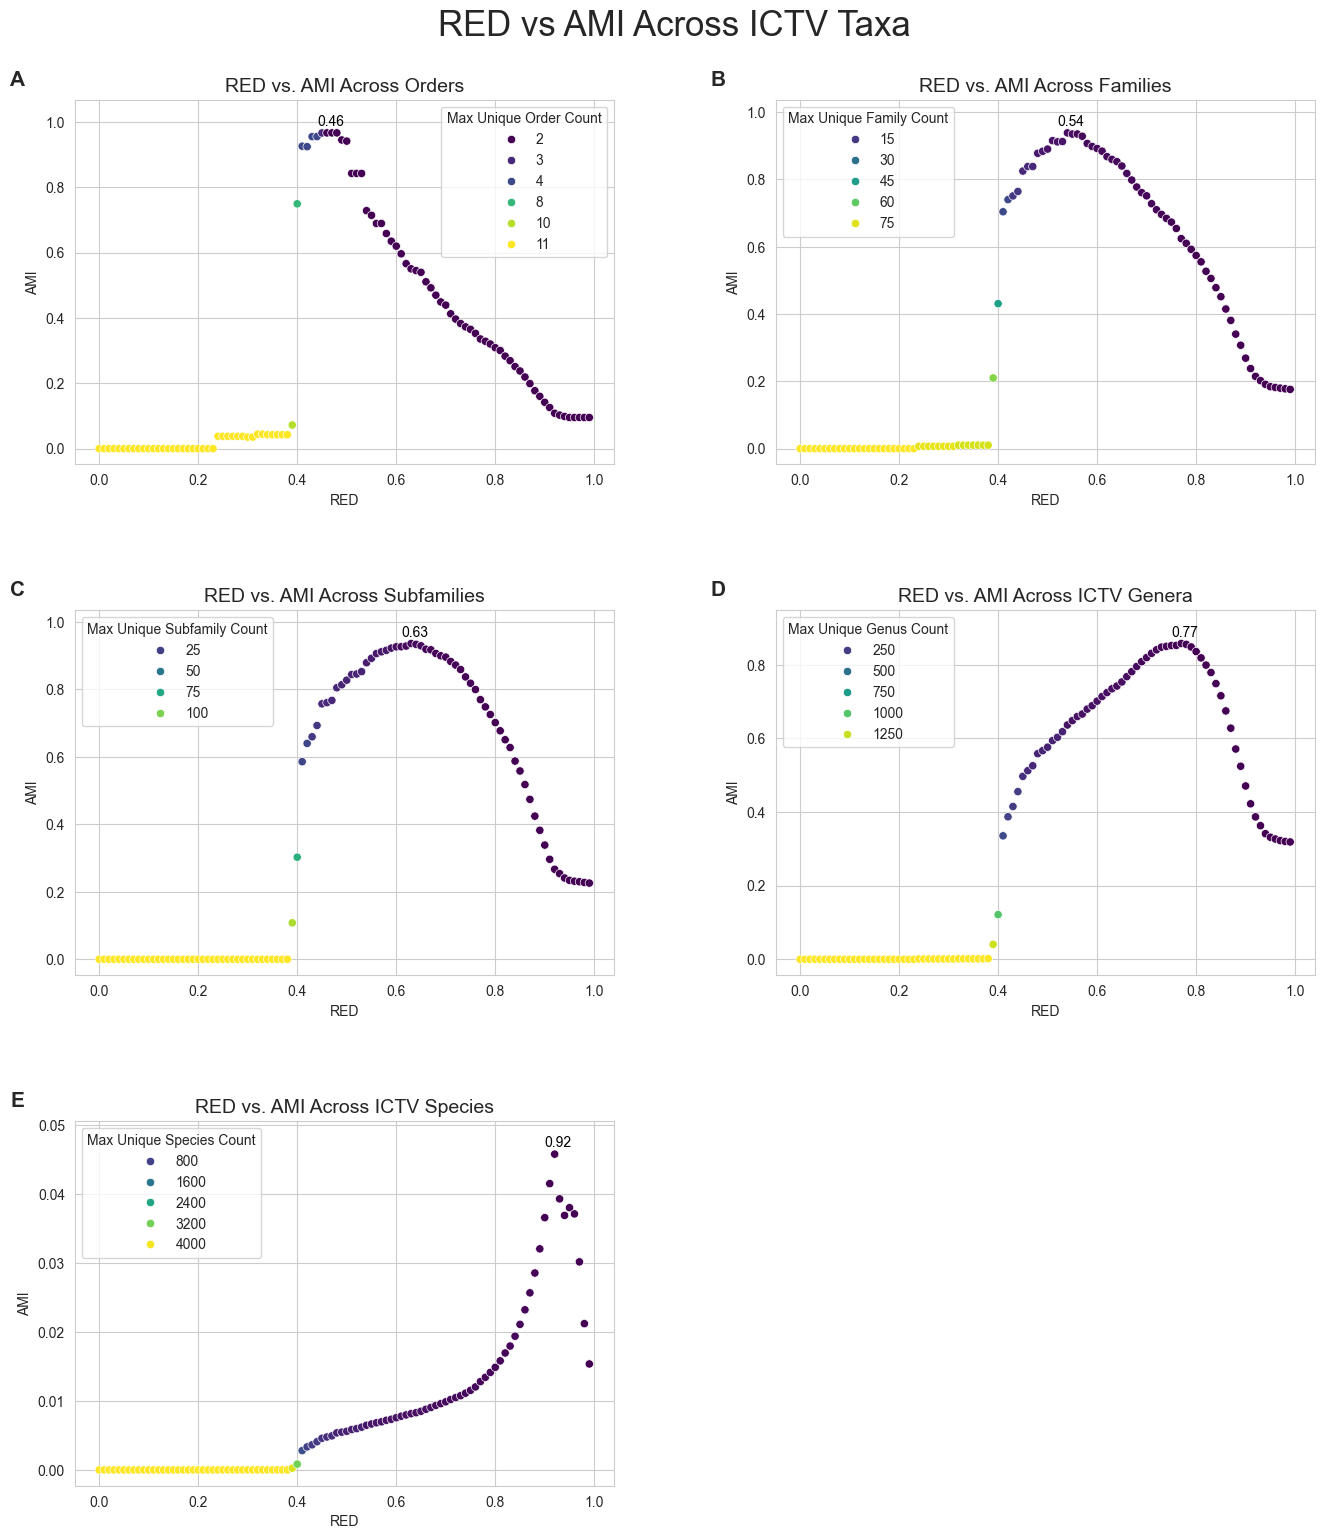

In [24]:
def annotate_max(data, x, y, ax):
    max_y = data[y].max()
    max_x = data[data[y] == max_y][x].iloc[0]
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + 0.05 * (ymax - ymin))
    ax.text(max_x - 0.02, max_y + 0.02 * (ymax - ymin), f"{max_x:.2f}", fontsize=10, color="black")

# Set up the figure with 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
# Add a supertitle
plt.suptitle('RED vs AMI Across ICTV Taxa', fontsize=25, fontweight='normal', y=0.93)

sns.set_style("whitegrid")

# Define label positions relative to each subplot
panel_labels = ['A', 'B', 'C', 'D', 'E']
positions = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]

# Plot titles and data
plots = [
    (order_ami_df, 'Max Unique Order Count', "RED vs. AMI Across Orders"),
    (family_ami_df, 'Max Unique Family Count', "RED vs. AMI Across Families"),
    (subfamily_ami_df, 'Max Unique Subfamily Count', "RED vs. AMI Across Subfamilies"),
    (genus_ami_df, 'Max Unique Genus Count', "RED vs. AMI Across ICTV Genera"),
    (species_ami_df, 'Max Unique Species Count', "RED vs. AMI Across ICTV Species"),
]

for i, ((df, hue_col, title), (r, c)) in enumerate(zip(plots, positions)):
    ax = axes[r, c]
    sns.scatterplot(data=df, x='RED', y='AMI', hue=hue_col, palette='viridis', ax=ax)
    ax.set_title(title, fontsize=14)
    annotate_max(df, 'RED', 'AMI', ax)
    ax.text(-0.12, 1.08, panel_labels[i], transform=ax.transAxes, 
            fontsize=15, fontweight='bold', va='top', ha='left')

# Hide unused bottom-right subplot
axes[2, 1].axis('off')

# Save and show
plt.savefig('../plots/RED_vs_AMI_score_04_07_25.png', bbox_inches='tight')
plt.show()

In [25]:
def percent_taxa_recovered(tree, red_cutoff, metadata, taxa_column):
    """
    Calculates the percentage of ICTV taxa that are monophyletic under a given RED cutoff.
    
    Returns:
    - percent_recovered: float (e.g., 87.5)
    - recovered_families: list of taxa recovered
    - unrecovered_families: list of polyphyletic taxa
    """
    # Step 1: Cut tree at RED threshold and assign clusters
    clusters = []
    for node in tree.traverse("preorder"):
        if hasattr(node, "RED") and float(node.RED) <= red_cutoff:
            clusters.append(node.get_leaf_names())

    tip_to_cluster = {}
    for cluster_id, cluster in enumerate(clusters):
        for tip in cluster:
            tip_to_cluster[tip] = cluster_id

    labeled_metadata = metadata[metadata["Leaf"].isin(tip_to_cluster.keys())].copy()
    labeled_metadata["Cluster"] = labeled_metadata["Leaf"].map(tip_to_cluster)

    # Step 2: For each taxon (e.g., family), check how many clusters its members are in
    taxa_to_clusters = labeled_metadata.groupby(taxa_column)["Cluster"].nunique()

    # Monophyletic = only found in 1 cluster
    monophyletic = taxa_to_clusters[taxa_to_clusters == 1]
    polyphyletic = taxa_to_clusters[taxa_to_clusters > 1]

    percent_recovered = 100 * len(monophyletic) / len(taxa_to_clusters)

    return percent_recovered, monophyletic.index.tolist(), polyphyletic.index.tolist()

In [26]:
order_red = 0.46
family_red = 0.54 
subfamily_red = 0.63
genus_red = 0.77

# Run percent recovery for each rank
order_percent, order_recovered, order_poly = percent_taxa_recovered(tree, order_red, metadata, "Order")
family_percent, family_recovered, family_poly = percent_taxa_recovered(tree, family_red, metadata, "Family")
subfam_percent, subfam_recovered, subfam_poly = percent_taxa_recovered(tree, subfamily_red, metadata, "Subfamily")
genus_percent, genus_recovered, genus_poly = percent_taxa_recovered(tree, genus_red, metadata, "Genus")

print(f"Order-level (RED = {order_red:.2f}): {order_percent:.1f}% of ICTV orders recovered as monophyletic")
print(f"Family-level (RED = {family_red:.2f}): {family_percent:.1f}% of ICTV families recovered as monophyletic")
print(f"Subfamily-level (RED = {subfamily_red:.2f}): {subfam_percent:.1f}% of ICTV subfamilies recovered as monophyletic")
print(f"Genus-level (RED = {genus_red:.2f}): {genus_percent:.1f}% of ICTV genera recovered as monophyletic")

Order-level (RED = 0.46): 54.5% of ICTV orders recovered as monophyletic
Family-level (RED = 0.54): 82.3% of ICTV families recovered as monophyletic
Subfamily-level (RED = 0.63): 82.3% of ICTV subfamilies recovered as monophyletic
Genus-level (RED = 0.77): 95.2% of ICTV genera recovered as monophyletic


In [27]:
pd.DataFrame({
    "Rank": ["Order", "Family", "Subfamily", "Genus"],
    "RED Threshold": [order_red, family_red, subfamily_red, genus_red],
    "% Monophyletic": [order_percent, family_percent, subfam_percent, genus_percent],
    "# Taxa Monophyletic": [len(order_recovered), len(family_recovered), len(subfam_recovered), len(genus_recovered)],
    "# Taxa Polyphyletic": [len(order_poly), len(family_poly), len(subfam_poly), len(genus_poly)]
})

,Rank,RED Threshold,% Monophyletic,# Taxa Monophyletic,# Taxa Polyphyletic
0,Order,0.46,54.545455,6,5
1,Family,0.54,82.278481,65,14
2,Subfamily,0.63,82.258065,102,22
3,Genus,0.77,95.245062,1302,65


# 4. Creating new orders, families, subfamilies, genera by cutting tree at RED ranges determined by AMI score

In [18]:
def find_MRCA_by_rank_and_range(tree, red_df, metadata, taxonomic_ranges=None, rank="Family"):
    """
    Finds the highest node/MRCA by taxa rank within specific RED value ranges.

    Parameters:
    - tree: The tree in ETE3 format.
    - red_df: A DataFrame of RED scores generated by PhyloRank.
    - metadata: A DataFrame containing metadata with columns "Leaf" and taxonomic ranks (e.g., "Family").
    - taxonomic_ranges: A dictionary mapping taxonomic ranks to RED value ranges. Default is pre-defined.
    - rank: The taxonomic rank to compare (default is "Family").

    Returns:
    - DataFrame of MRCA nodes and RED scores for all monophyletic and polyphyletic clades by rank.
    """
    if taxonomic_ranges is None:
        taxonomic_ranges = {
            'Order': (0.46, 0.54),
            'Family': (0.54, 0.63),
            'Subfamily': (0.63, 0.77),
            'Genus': (0.77, 0.92),
            'Species': (0.92, 1)
        }

    if rank not in taxonomic_ranges:
        raise ValueError(f"Rank '{rank}' is not defined in the taxonomic ranges.")

    results = []
    undefined_leaves = metadata[pd.isna(metadata[rank])]["Leaf"].values
    red_min, red_max = taxonomic_ranges[rank]

    for _, row in tqdm(red_df.iterrows(), total=len(red_df), desc="Processing REDs"):
        # Split pair into two leaves
        pair = row["Node"].split("|")
        if len(pair) != 2:
            continue
        leaf1, leaf2 = pair
        red_value = row["RED"]

        # Skip if the RED value is outside the range for the rank
        if not (red_min <= red_value < red_max):
            continue

        # Find MRCA of the two leaves
        try:
            mrca = tree.get_common_ancestor(leaf1, leaf2)
            if not mrca.name:
                mrca.name = f"MRCA_{leaf1}_{leaf2}"
        except:
            continue  # Skip if one of the leaves is not in the tree

        # Assign RED value to the MRCA
        mrca.add_feature("RED", red_value)

        # Get metadata for the leaves under MRCA
        leaves = mrca.get_leaf_names()
        metadata_subset = metadata.loc[metadata["Leaf"].isin(leaves), rank]

        # Count descendant leaves
        descendant_count = len(leaves)
        undefined_leaves_in_mrca = [leaf for leaf in leaves if leaf in undefined_leaves]
        undefined_leaves_count = len(undefined_leaves_in_mrca)

        # Get unique taxonomic classifications within this MRCA
        defined_rank_counts = metadata_subset.dropna().value_counts().to_dict()
        if undefined_leaves_count > 0:
            defined_rank_counts["Undefined"] = undefined_leaves_count

        # Determine the highest node where the taxa are monophyletic
        highest_node = find_highest_shared_node(mrca, metadata, leaves, rank)

        if len(defined_rank_counts) <= 1:  # Monophyletic or mostly undefined
            assigned_rank = list(defined_rank_counts.keys())[0] if defined_rank_counts else "Undefined"
            results.append({
                "Pair": pair,
                "MRCA": mrca.name,
                "RED": red_value,
                f"{rank}": assigned_rank,
                "Highest Node": highest_node.name if highest_node else None,
                'Leaves': leaves,
                "Descendant Leaves Count": descendant_count,
                "Undefined Leaves": ", ".join(undefined_leaves_in_mrca) if undefined_leaves_in_mrca else "None",
                "Undefined Leaves Count": undefined_leaves_count,
                "Rank Count": len(defined_rank_counts),
                "Defined Rank Counts": defined_rank_counts
            })
        else:  # Polyphyletic case
            results.append({
                "Pair": pair,
                "MRCA": mrca.name,
                "RED": red_value,
                f"{rank}": ", ".join(map(str, defined_rank_counts.keys())),
                "Highest Node": highest_node.name if highest_node else None,
                'Leaves': leaves,
                "Descendant Leaves Count": descendant_count,
                "Undefined Leaves": ", ".join(undefined_leaves_in_mrca) if undefined_leaves_in_mrca else "None",
                "Undefined Leaves Count": undefined_leaves_count,
                "Rank Count": len(defined_rank_counts),
                "Defined Rank Counts": defined_rank_counts
            })

    return pd.DataFrame(results)

def find_highest_shared_node(node, metadata, leaves, rank="Family"):
    """
    Finds the highest node where all provided leaves share the same taxonomic classification.

    Parameters:
    - node: The current node in the tree.
    - metadata: A DataFrame containing metadata with columns "Leaf" and the rank (e.g., "Family").
    - leaves: A list of leaves to check.
    - rank: The taxonomic rank to compare (default is "Family").

    Returns:
    - The highest node where all provided leaves share the same classification.
    """
    # Get the unique ranks present among the leaves
    target_ranks = set(metadata[metadata["Leaf"].isin(leaves)][rank].dropna())

    while node.up:
        parent = node.up
        parent_leaves = parent.get_leaf_names()
        
        # Get ranks for the parent's leaves, including NaN
        parent_ranks = set(metadata[metadata["Leaf"].isin(parent_leaves)][rank].dropna())
        
        # If parent ranks match the target ranks, move up
        if parent_ranks == target_ranks:
            node = parent
        else:
            break
    return node

In [23]:
order_MRCAs_df = find_MRCA_by_rank_and_range(tree, REDs, metadata, rank="Order")
family_MRCAs_df = find_MRCA_by_rank_and_range(tree, REDs, metadata, rank="Family")
subfamily_MRCAs_df = find_MRCA_by_rank_and_range(tree, REDs, metadata, rank="Subfamily")
genus_MRCAs_df = find_MRCA_by_rank_and_range(tree, REDs, metadata, rank="Genus")

Processing REDs: 100%|████████████████████████████████████████████████████████████| 8165/8165 [00:17<00:00, 462.95it/s]


## Generate RED taxa gradient visualization (supplementary figure 7)

In [ ]:
# import my itol scripts for quick annotation creation
from itol_tools import write_itol_metadata_from_reds

# Write all RED node values to iTol annotation format
write_itol_metadata_from_reds(REDs, "../iTOL_annotation/RED_MRCAs/RED_MRCA_NODE_LABELS.txt")

# === INPUT DATA ===
df = REDs  # This is your DataFrame with columns: Node, RED
output_itol_file = "../iTOL_annotation/RED_MRCAs/itol_RED_TREE_COLORS.txt"

# === RED-BASED TAXONOMIC RANGES ===
taxonomic_ranges = {
    'Order': (0.46, 0.54),
    'Family': (0.54, 0.63),
    'Subfamily': (0.63, 0.77),
    'Genus': (0.77, 0.92),
    'Species': (0.92, 1.0)
}
buffer = 0.02
adjusted_ranges = {
    rank: (max(0, low - buffer), min(1, high + buffer))
    for rank, (low, high) in taxonomic_ranges.items()
}

# === COLORS FOR iTOL LEGEND ===
rank_colors = {
    'Order': '#1f78b4',      # blue
    'Family': '#33a02c',     # green
    'Subfamily': '#FFBF00',  # yellow
    'Genus': '#e31a1c',      # red
    'Species': '#6a3d9a',    # purple
    'Unassigned': '#bdbdbd'  # gray
}

# === FUNCTION TO ASSIGN RANK ===
def assign_rank(red):
    for rank, (low, high) in taxonomic_ranges.items():
        if low <= red < high:
            return rank
    for rank, (low, high) in adjusted_ranges.items():
        if low <= red < high:
            return f"{rank}_borderline"
    return "Unassigned"

df['assigned_rank'] = df['RED'].apply(assign_rank)
df['assigned_rank_base'] = df['assigned_rank'].str.replace('_borderline', '', regex=False)
df['color'] = df['assigned_rank_base'].map(rank_colors).fillna('#CCCCCC')

legend_ranks = ['Order', 'Family', 'Subfamily', 'Genus', 'Species']

# === WRITE TREE_COLORS FILE ===
with open(output_itol_file, 'w') as f:
    f.write("TREE_COLORS\n")
    f.write("SEPARATOR SPACE\n")
    f.write("SHOW_LEGEND 1\n")
    f.write("LEGEND_TITLE RED Taxonomic Ranks\n")
    f.write("LEGEND_SHAPES " + " ".join(['1'] * len(legend_ranks)) + "\n")
    f.write("LEGEND_COLORS " + " ".join([rank_colors[r] for r in legend_ranks]) + "\n")
    f.write("LEGEND_LABELS " + " ".join(legend_ranks) + "\n")
    f.write("DATA\n")  # No blank line before or after this

    for _, row in df.iterrows():
        node = row['Node']
        color = row['color']
        f.write(f"{node} branch {color} normal 5\n")

In [26]:
def find_optimal_MRCAs(df, rank='Family'):
    """
    Identifies the optimal Most Recent Common Ancestors (MRCAs) for a given taxonomic rank 
    by selecting nodes that collectively cover all leaves with minimal redundancy.

    Parameters:
    - df (pd.DataFrame): A DataFrame containing MRCA information, including columns 
      such as 'MRCA', 'RED', 'Leaves', 'Descendant Leaves Count', and the specified rank.
    - rank (str, optional): The taxonomic rank to group by (default is 'Family').

    Returns:
    - pd.DataFrame: A DataFrame containing the optimal set of MRCAs that collectively 
      cover all leaves while minimizing overlap and redundancy.
    
    Method:
    1. Groups the input DataFrame by the specified taxonomic rank.
    2. Iterates through each group, sorting by RED score (lower is better).
    3. Selects MRCAs that contribute the most unique leaves while avoiding redundancy.
    4. Stops when all leaves in the group are covered.
    5. Further filters to prioritize MRCAs with the highest 'Descendant Leaves Count'.
    6. Ensures that selected MRCAs do not overlap with previously chosen ones.

    Notes:
    - The function prioritizes MRCAs with the lowest RED values, ensuring 
      taxonomic accuracy while minimizing redundancy.
    - If two MRCAs share leaves, the function selects the one that contributes the 
      most unique leaves to avoid over-representing any taxon.

    """
    selected_mrcas = []

    # Group by 'Family' and process each group
    for taxa, group_df in df.groupby(rank):
        print("Processing Family:", taxa)
        
        all_leaves_set = set(leaf for leaves in group_df['Leaves'] for leaf in leaves)
        collected_leaves = set()
        
        # Sort the DataFrame by RED score in ascending order (lower is better)
        group_df = group_df.sort_values(by='RED')
        
        for _, row in group_df.iterrows():
            mrca = row['MRCA']
            traversed_leaves = set(row['Leaves'])
            
            # Check if this MRCA has any overlap with the previously collected leaves
            overlap_leaves = traversed_leaves.intersection(collected_leaves)
            
            # If there is an overlap, we need to compare which MRCA has more unique leaves
            if overlap_leaves:
                # Calculate how many new leaves this MRCA would contribute
                new_leaves = traversed_leaves - collected_leaves
                if len(new_leaves) > 0:
                    collected_leaves.update(new_leaves)
                    selected_mrcas.append(mrca)
            else:
                # If there is no overlap, add this MRCA to the selected list
                collected_leaves.update(traversed_leaves)
                selected_mrcas.append(mrca)
            
            # If all leaves are collected, stop processing this group
            if collected_leaves == all_leaves_set:
                break
    
    df_MRCAs = df[df.MRCA.isin(selected_mrcas)]

    group = df_MRCAs.sort_values(by="Descendant Leaves Count", ascending=False).reset_index(drop=True)
    
    # Track unique leaves
    resolved_rows = []
    seen_leaves = set()

    for _, row in group.iterrows():
        current_leaves = set(row["Leaves"])
        
        # Check for overlap with already seen leaves
        if not seen_leaves.intersection(current_leaves):
            resolved_rows.append(row)
            seen_leaves.update(current_leaves)
    
    return pd.DataFrame(resolved_rows)

# 4.1 Orders

In [34]:
order_MRCA_RED_cuts = find_optimal_MRCAs(order_MRCAs_df, rank='Order')

Processing Family: Adrikavirales, Undefined
Processing Family: Autographivirales, Undefined
Processing Family: Crassvirales
Processing Family: Crassvirales, Undefined
Processing Family: Grandevirales, Undefined
Processing Family: Juravirales, Kirjokansivirales
Processing Family: Juravirales, Methanobavirales
Processing Family: Kirjokansivirales
Processing Family: Kirjokansivirales, Undefined
Processing Family: Magrovirales, Juravirales
Processing Family: Magrovirales, Undefined
Processing Family: Nakonvirales, Undefined
Processing Family: Pantevenvirales, Grandevirales, Undefined
Processing Family: Pantevenvirales, Undefined
Processing Family: Thumleimavirales
Processing Family: Thumleimavirales, Undefined
Processing Family: Undefined


## Evaluate edge cases where clades are *very* slightly outside of predetermined range...

In [25]:
def evaluate_provisional_clades(
    tree, metadata, mrca_red_cuts, rank,
    red_range=(0.46, 0.54),
    red_buffer=0.01,
    min_leaves=10
):
    """
    Find and evaluate undefined clades for provisional taxonomic rank assignment.

    Returns:
    - DataFrame with columns:
        MRCA_name, RED, Leaves, n_leaves, Include, Outlier, RED_outlier_amount
    """

    # Step 1: Assigned leaves
    assigned_leaves = set()
    for leaves in mrca_red_cuts["Leaves"]:
        assigned_leaves.update(leaves)

    # Step 2: All leaf names
    all_leaves = set(metadata["Leaf"])
    undefined_leaves = all_leaves - assigned_leaves

    clade_rows = []

    for node in tree.traverse("postorder"):
        leaf_names = set(leaf.name for leaf in node.iter_leaves())

        if leaf_names.issubset(undefined_leaves):
            parent = node.up
            if parent is None or not set(leaf.name for leaf in parent.iter_leaves()).issubset(undefined_leaves):
                red = getattr(node, "RED", None)
                n = len(leaf_names)

                # Count how many leaves are already assigned to a known label at this rank
                defined_ranks = metadata[metadata["Leaf"].isin(leaf_names)][rank]
                rank_counts = defined_ranks.value_counts().to_dict()

                include = False
                outlier = False
                red_outlier_amount = None

                if red is not None:
                    in_range = red_range[0] <= red <= red_range[1]
                    in_buffer = (
                        (red_range[0] - red_buffer) <= red <= (red_range[1] + red_buffer)
                    )
                    include = n >= min_leaves and in_buffer
                    outlier = not in_buffer
                    red_outlier_amount = 0.0 if in_range else min(
                        abs(red - red_range[0]),
                        abs(red - red_range[1])
                    )

                clade_rows.append({
                    "MRCA": node.name,
                    "RED": red,
                     rank: max(rank_counts.items(), key=lambda x: x[1])[0] if rank_counts else "Undefined",
                    "Leaves": leaf_names,
                    "n_leaves": n,
                    "Include": include,
                    "Buffer_outlier": outlier,
                    "RED_outlier_amount": red_outlier_amount,
                    "Rank": rank,
                    "Defined Rank Counts": rank_counts
                    })


    df = pd.DataFrame(clade_rows)
    return df.sort_values(by=["Include", "n_leaves"], ascending=[False, False])

In [89]:
df_orders_provisional = evaluate_provisional_clades(
    tree,
    metadata,
    order_MRCA_RED_cuts,
    rank='Order',
    red_range=(0.46, 0.54),
    red_buffer=0.03,
    min_leaves=2
)

In [90]:
df_orders_provisional[df_orders_provisional['Leaves'].apply(lambda s: 'NC_055759' in s)]

,MRCA,RED,Order,Leaves,n_leaves,Include,Buffer_outlier,RED_outlier_amount,Rank,Defined Rank Counts
26,NC_004685_NC_023712_0.78282,0.78282,Undefined,"{NC_055759, NC_004685, NC_022057, NC_023712}",4,False,True,0.24282,Order,{}


In [91]:
df_orders_provisional.n_leaves.sum()

471

In [41]:
# include these borderline orders to preserve maximum data..
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_001835_NC_055050_0.634327','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_048796_NC_041902_0.613118','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_055905_NC_021336_0.63688','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_070761_NC_048176_0.591823','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='BK063678_NC_001902_0.235472','Include'] = True

In [43]:
# these are definitely outliers but should be assigned top-down rank of order when visualized on the tree..
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_074641_PP537965_0.391764','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_021789_NC_021803_0.694051','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_021788_NC_021798_0.879871','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_019512_NC_019931_0.677418','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_019541_NC_041866_0.737127','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_005856_NC_042128_0.760578','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_004685_NC_023712_0.78282','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_028930_NC_055029_0.705475','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_008562_NC_029002_0.81223','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_042348_NC_042350_0.818876','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_021319_NC_021340_0.668175','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_023559_NC_023571_0.749343','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_021788_NC_021798_0.879871','Include'] = True
df_orders_provisional.loc[df_orders_provisional.MRCA=='NC_004685_NC_023712_0.78282','Include'] = True

In [44]:
orders_to_define = df_orders_provisional[df_orders_provisional.Include==True]

In [45]:
# 107 orders.. 😵‍💫
orders = pd.concat([order_MRCA_RED_cuts, orders_to_define])
orders.shape

(107, 16)

In [46]:
conflicting_mrcas = (
    orders.groupby(["MRCA", "Order"])
    .size()  # instead of ["Order"].count()
    .rename("count")
    .reset_index()
    .sort_values(by='MRCA')
)

# Now filter to MRCA nodes assigned to multiple Orders
mrca_order_counts = conflicting_mrcas.groupby("MRCA")["Order"].nunique()
conflicted_mrcas = mrca_order_counts[mrca_order_counts > 1].index

# Show the conflicting rows
conflicting_mrcas[conflicting_mrcas["MRCA"].isin(conflicted_mrcas)]

,MRCA,Order,count


In [47]:
orders["New Order Name"] = orders["Order"].str.split(',').str[0]

In [48]:
def fill_undefined_with_max_family(df, metadata):
    df = df.copy()

    for i, row in df[df["New Order Name"] == "Undefined"].iterrows():
        clade_leaves = row["Leaves"]
        filtered = metadata[metadata["Leaf"].isin(clade_leaves)]
        families = filtered["Family"].dropna()

        if families.empty:
            df.at[i, "New Order Name"] = "Undefined"
        else:
            df.at[i, "New Order Name"] = families.value_counts().idxmax()

    return df

In [49]:
orders_undefined = orders[orders['New Order Name']=='Undefined']
orders_undefined = fill_undefined_with_max_family(orders_undefined, metadata)
orders_undefined['New Order Name'] = orders_undefined['New Order Name'].str.replace('viridae','virales')
orders_defined = orders[orders['New Order Name']!='Undefined']
orders = pd.concat([orders_defined, orders_undefined])

In [50]:
def disambiguate_names(df, column='New Order Name', undefined_value='Undefined'):
    """
    Appends _1, _2, etc. to duplicate values in a specified column of a DataFrame,
    excluding rows with a defined 'undefined_value'. Genuinely suffixed values (e.g., 'Name_1')
    are preserved and not stripped or modified.

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - column (str): Column to disambiguate
    - undefined_value (str): Value to exclude from processing (e.g., 'Undefined')

    Returns:
    - pd.DataFrame: Modified DataFrame with disambiguated names
    """
    from collections import Counter

    df = df.copy()  # avoid modifying original

    # Mask to select only defined rows
    mask = df[column] != undefined_value

    # Count occurrences
    name_counts = df.loc[mask, column].value_counts()

    # Identify duplicates
    dupes = name_counts[name_counts > 1].index

    # Apply suffixes to duplicates only
    df.loc[mask, column] = (
        df.loc[mask]
        .groupby(column)
        .cumcount()
        .add(1)
        .astype(str)
        .where(df.loc[mask, column].isin(dupes), '')
        .radd(df.loc[mask, column] + df.loc[mask, column].isin(dupes).map({True: '_', False: ''}))
    )

    return df

In [51]:
from collections import Counter

# Mask to select only defined names
mask = orders['New Order Name'] != 'Undefined'

# Work only with these rows
defined_names = orders.loc[mask, 'New Order Name']

# Count name occurrences
name_counts = defined_names.value_counts()

# Identify duplicates
dupes = name_counts[name_counts > 1].index

# Use groupby + cumcount to number duplicates, skip unique names
orders.loc[mask, 'New Order Name'] = (
    orders.loc[mask]
    .groupby('New Order Name')
    .cumcount()
    .add(1)
    .astype(str)
    .where(orders.loc[mask, 'New Order Name'].isin(dupes), '')
    .radd(orders.loc[mask, 'New Order Name'] + orders.loc[mask, 'New Order Name'].isin(dupes).map({True: '_', False: ''}))
)

In [52]:
orders.loc[orders["New Order Name"] == "Undefined", "New Order Name"] = [
    f"Undefined_{i+1}" for i in range((orders["New Order Name"] == "Undefined").sum())
]

In [53]:
sorted(orders['New Order Name'].unique())[0:10]

['Adrikavirales',
 'Aliceevansvirales',
 'Assiduvirales',
 'Autographivirales',
 'Crassvirales',
 'Drexlervirales_1',
 'Drexlervirales_2',
 'Dunevirales_1',
 'Dunevirales_2',
 'Juravirales_1']

In [144]:
# === iTOL annotation file showing Order MRCAs only ===
orders_df = orders
output_itol_file = "../iTOL_annotation/RED_MRCAs/itol_orders_nodes_only.txt"

default_color = "#ff00ff"

# === WRITE FILE ===
with open(output_itol_file, 'w') as f:
    f.write("TREE_COLORS\n")
    f.write("SEPARATOR SPACE\n\n")
    f.write("SHOW_LEGEND 0\n")

    f.write("DATA\n")
    for mrca in orders_df["MRCA"]:
        f.write(f"{mrca} node {default_color} normal 5\n")

# Create iTOL annotation file to view the order clades on the tree...

In [71]:
import importlib
import itol_tools
importlib.reload(itol_tools)

from itol_tools import create_itol_tree_colors_from_mrca
from itol_tools import create_itol_tree_colors_from_mrca, find_midpoint_leaf_from_mrca

In [72]:
color_map, label_map = create_itol_tree_colors_from_mrca(
    orders, "../iTOL_annotation/RED_MRCAs/RED_scaled_order_clade_colours.txt", seed=10
)

✅ TREE_COLORS file written to: ../iTOL_annotation/RED_MRCAs/RED_scaled_order_clade_colours.txt


In [73]:
# Create label mapping from the 'New Order Name' column
label_mapping = dict(zip(orders['MRCA'], orders['New Order Name']))

# Then pass this into the function along with the original color_mapping
find_midpoint_leaf_from_mrca(
    tree,
    metadata_df=orders,
    color_mapping=color_map,
    output_file='../iTOL_annotation/RED_MRCAs/RED_scaled_order_clade_colours_midpoint_labels.txt',
    rank='New Order Name',
    label='Order labels',
    legend_title='Order',
    label_mapping=label_mapping
)

✅ iTOL midpoint annotation file written to: ../iTOL_annotation/RED_MRCAs/RED_scaled_order_clade_colours_midpoint_labels.txt


# 4.2 Define new families..

In [27]:
family_MRCA_RED_cuts = find_optimal_MRCAs(family_MRCAs_df, rank='Family')

Processing Family: Ackermannviridae
Processing Family: Ackermannviridae, Undefined
Processing Family: Aliceevansviridae
Processing Family: Aliceevansviridae, Undefined
Processing Family: Aoguangviridae, Apasviridae
Processing Family: Arenbergviridae, Undefined
Processing Family: Assiduviridae
Processing Family: Autographiviridae, Unassigned
Processing Family: Autonotataviridae, Autoscriptoviridae, Autographiviridae, Unassigned
Processing Family: Autonotataviridae, Autoscriptoviridae, Unassigned, Autographiviridae
Processing Family: Autoscriptoviridae, Autonotataviridae
Processing Family: Autoscriptoviridae, Autonotataviridae, Autographiviridae, Unassigned
Processing Family: Autoscriptoviridae, Autonotataviridae, Unassigned, Autographiviridae
Processing Family: Autotranscriptaviridae, Autographiviridae, Unassigned
Processing Family: Autotranscriptaviridae, Unassigned
Processing Family: Autotranscriptaviridae, Unassigned, Autographiviridae
Processing Family: Casjensviridae
Processing Fam

In [28]:
# 140 families
family_MRCA_RED_cuts.MRCA.nunique()

140

In [29]:
family_MRCA_RED_cuts["New Family Name"] = family_MRCA_RED_cuts["Family"].str.split(',').str[0]

In [30]:
# add suffixes to dupe families e.g. rountree_1 rountree_2
family_MRCA_RED_cuts['New Family Name'] = family_MRCA_RED_cuts['New Family Name'].where(
    family_MRCA_RED_cuts['New Family Name'] != 'Undefined',
    'Undefined_' + (family_MRCA_RED_cuts.groupby('New Family Name').cumcount() + 1).astype(str)
)

In [31]:
mask = family_MRCA_RED_cuts['New Family Name'] != 'Undefined'

# Apply groupby and cumcount only on non-Undefined rows
family_MRCA_RED_cuts.loc[mask, 'New Family Name'] = (
    family_MRCA_RED_cuts[mask]
    .groupby('New Family Name')
    .cumcount()
    .add(1)
    .astype(str)
    .radd(family_MRCA_RED_cuts.loc[mask, 'New Family Name'] + '_')
)

# If count was 1, remove the suffix to preserve original name
#family_MRCA_RED_cuts['New Family Name'] = family_MRCA_RED_cuts['New Family Name'].str.replace(r'_1$', '', regex=True)

In [32]:
family_MRCA_RED_cuts['New Family Name'].nunique()

140

In [33]:
df_families_provisional = evaluate_provisional_clades(
    tree,
    metadata,
    family_MRCA_RED_cuts,
    rank='Family',
    red_range=(0.54, 0.63),
    red_buffer=0.03,
    min_leaves=1
)

In [93]:
df_families_provisional[df_families_provisional['Leaves'].apply(lambda s: 'NC_021320' in s)]

,MRCA,RED,Family,Leaves,n_leaves,Include,Buffer_outlier,RED_outlier_amount,Rank,Defined Rank Counts
63,NC_004927_NC_062740_0.785727,0.785727,Hafunaviridae,"{NC_021320, NC_021321, NC_062740, NC_062755, N...",7,False,True,0.155727,Family,{'Hafunaviridae': 7}


In [94]:
df_families_provisional[df_families_provisional['Leaves'].apply(lambda s: 'NC_041972' in s)]

,MRCA,RED,Family,Leaves,n_leaves,Include,Buffer_outlier,RED_outlier_amount,Rank,Defined Rank Counts
60,NC_023557_NC_042098_0.805857,0.805857,Chimalliviridae,"{NC_041973, NC_023557, NC_042098, NC_041972, N...",6,False,True,0.175857,Family,{'Chimalliviridae': 6}


In [95]:
df_families_provisional[df_families_provisional['Leaves'].apply(lambda s: 'NC_055789' in s)]

,MRCA,RED,Family,Leaves,n_leaves,Include,Buffer_outlier,RED_outlier_amount,Rank,Defined Rank Counts
97,NC_055788_NC_028653_0.721059,0.721059,Zierdtviridae,"{NC_055767, NC_055758, NC_055738, NC_055731, N...",20,False,True,0.091059,Family,{'Zierdtviridae': 20}


In [87]:
df_families_provisional[2:5]

,MRCA,RED,Family,Leaves,n_leaves,Include,Outlier,RED_outlier_amount,Rank,Defined Rank Counts
11,NC_004831_NC_047802_0.633203,0.633203,Autosignataviridae,"{NC_047889, NC_047821, NC_047807, NC_047769, N...",36,True,False,0.003203,Family,"{'Autosignataviridae': 34, 'Autographiviridae'..."
111,NC_005282_NC_048080_0.529574,0.529574,Undefined,"{NC_071010, NC_028825, NC_011811, NC_048074, N...",29,True,False,0.010426,Family,{}
4,NC_055905_NC_021336_0.63688,0.636880,Salasmaviridae,"{NC_049969, NC_031015, NC_049968, NC_049959, N...",15,True,False,0.006880,Family,{'Salasmaviridae': 15}


In [113]:
df_families_provisional.shape

(131, 10)

In [41]:
already_included = set(df_families_provisional[df_families_provisional.Include == True].MRCA)

# MRCAs manually included after visualizing clades on tree
manual_mrcas_to_include = [
    'NC_041884',
    'NC_006552_NC_062747_0.481915',
    'NC_002519_NC_048671_0.689729',
    'NC_047757_NC_020842_0.479928',
    'NC_048040_NC_048141_0.697437',
    'NC_047983_NC_047909_0.506695',
    'NC_062744_NC_021803_0.442727',
    'NC_048756_NC_048637_0.766283',
    'NC_062748',
    'NC_062746_NC_062745_0.789347',
    'NC_031914_NC_041872_0.823975',
    'NC_019512_NC_019931_0.677418',
    'NC_055711_NC_042020_0.499752',
    'NC_027204_NC_041929_0.8093',
    'NC_062752_NC_062751_0.877948',
    'NC_042032_NC_024138_0.800523',
    'NC_048027_NC_048028_0.91496',
    'NC_023744',
    'NC_031231_NC_054393_0.467882',
    'NC_004685_NC_023712_0.78282',
    'NC_047756_NC_055033_0.478572',
    'NC_048188_NC_048187_0.805212',
    'NC_048772_NC_048770_0.767809',
    'NC_048843_NC_048831_0.460885',
    'NC_028763_NC_028924_0.837732',
    'NC_048121_NC_048125_0.792604',
    'NC_015933_NC_070870_0.713169',
    'NC_000924_NC_049941_0.502556',
    'NC_028930_NC_009804_0.457915',
    'NC_020477_NC_022766_0.78198',
    'NC_023582_NC_024355_0.797521',
    'NC_019515_NC_055035_0.446188',
    'NC_048106_NC_055915_0.485035',
    'NC_048789_NC_048791_0.798106',
    'NC_048848_NC_025420_0.497667',
    'NC_020883_NC_041918_0.503204',
    'NC_026590_NC_041987_0.494886',
    'NC_055745_NC_053173_0.696453',
    'NC_020079_NC_052663_0.702367',
    'NC_004927_NC_062740_0.785727',
    'NC_023557_NC_042098_0.805857',
    'NC_042109_NC_047851_0.498545',
    'NC_055788_NC_028653_0.721059',
    'NC_048706_NC_048854_0.711319',
    'NC_002656_NC_042326_0.738455',
    'NC_030932_NC_054435_0.691519',
    'NC_054988_NC_049805_0.450664',
    'NC_008364',
    'NC_048022_NC_047792_0.476864',
    'NC_022980_NC_041976_0.769861',
    'NC_042022_NC_023595_0.7567',
    'NC_054985',
    'NC_013643_NC_049812_0.463192',
    'NC_005178_NC_027298_0.805368',
    'NC_047861_NC_019930_0.488202'
]

new_inclusions = [mrca for mrca in manual_mrcas_to_include if mrca not in already_included]
df_families_provisional.loc[df_families_provisional.MRCA.isin(new_inclusions), 'Include'] = True

In [99]:
families_to_define = df_families_provisional[df_families_provisional.Include==True]

In [100]:
families = pd.concat([family_MRCA_RED_cuts, families_to_define])

In [101]:
families["New Family Name"] = families["Family"].str.split(',').str[0]

In [102]:
families = disambiguate_names(families, column='New Family Name', undefined_value='Undefined')

In [103]:
mask = families['New Family Name'] == 'Undefined'
families.loc[mask, 'New Family Name'] = (
    families[mask]
    .groupby('New Family Name')
    .cumcount()
    .add(1)
    .astype(str)
    .radd(families.loc[mask, 'New Family Name'] + '_')
)

In [104]:
families["New Family Name"].nunique()

217

In [58]:
#families['New Family Name'] = families['New Family Name'].str.replace(r'_1$', '', regex=True)

In [105]:
from itol_tools import create_itol_tree_colors_from_mrca, find_midpoint_leaf_from_mrca

In [106]:
annotation_file = '../iTOL_annotation/family_colours/family_clade_colours.txt'

import matplotlib.colors as mcolors
import colorsys
import textwrap

def parse_original_annotation(annotation_file):
    """
    Parses an iTOL annotation file to extract family-to-color mappings.
    
    Args:
        annotation_file (str): Path to the iTOL annotation file.
    
    Returns:
        dict: A dictionary where keys are family names (from lines starting with `#`)
              and values are dictionaries containing MRCA identifiers and colors.
              Example:
              {
                  'Chaseviridae': {
                      'NC_048629|NC_070972': {'color': '#64ccfc'},
                      'NC_004678|NC_024149': {'color': '#00008B'}
                  }
              }
    """
    family_color_mapping = {}
    current_family = None  # To keep track of the current family name

    with open(annotation_file, 'r') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith("# "):  # Detect family name
                current_family = line[2:].strip().split('_')[0]  # Extract text after '# '
                if current_family not in family_color_mapping:
                    family_color_mapping[current_family] = {}
            
            elif current_family and line:  # Process MRCA identifiers and colors
                parts = line.split()
                if len(parts) >= 3:
                    color = parts[2]  # Extract the color (hex code)
                    
                    family_color_mapping[current_family] = color
    
    return family_color_mapping

# Parse the original annotation file
family_color_mapping = parse_original_annotation(annotation_file)

In [107]:
color_map, label_map = create_itol_tree_colors_from_mrca(families,
                                  '../iTOL_annotation/RED_MRCAs/RED_scaled_FAMILY_clade_colours.txt',
                                  rank='Family',
                                  predefined_colors=family_color_mapping)

❌ Could not parse MRCA: NC_062748
❌ Could not parse MRCA: NC_041884
❌ Could not parse MRCA: NC_054985
❌ Could not parse MRCA: NC_008364
❌ Could not parse MRCA: NC_023744
✅ TREE_COLORS file written to: ../iTOL_annotation/RED_MRCAs/RED_scaled_FAMILY_clade_colours.txt


In [108]:
find_midpoint_leaf_from_mrca(
    tree,
    metadata_df=families,
    color_mapping=color_map,
    output_file='../iTOL_annotation/RED_MRCAs/RED_scaled_family_clade_midpoints.txt',
    rank='New Family Name',
    label='Family labels',
    legend_title='Family',
    label_mapping=label_map
)

✅ iTOL midpoint annotation file written to: ../iTOL_annotation/RED_MRCAs/RED_scaled_family_clade_midpoints.txt


# Create master metadata table of new taxonomic assignments

In [109]:
order_df = orders[['New Order Name', 'MRCA', 'Leaves']]\
.explode('Leaves') \
.reset_index(drop=True) \
.rename(columns={'MRCA':'Order MRCA','New Order Name':'Order'})

In [110]:
family_df = families[['New Family Name', 'MRCA', 'Leaves']]\
.explode('Leaves') \
.reset_index(drop=True) \
.rename(columns={'MRCA':'Family MRCA','New Family Name':'Family'})

In [111]:
RED_taxonomy = order_df.merge(family_df, left_on='Leaves',right_on='Leaves', how='outer')

In [112]:
RED_taxonomy.Family.nunique()

217

# 4.3 Define new subfamilies

In [115]:
optimal_subfamily_mrcas = find_optimal_MRCAs(subfamily_MRCAs_df, 'Subfamily')

Processing Family: Andregratiavirinae, Undefined
Processing Family: Andrewesvirinae
Processing Family: Arquatrovirinae
Processing Family: Asinivirinae
Processing Family: Azeevirinae
Processing Family: Azeredovirinae
Processing Family: Bastillevirinae
Processing Family: Bclasvirinae
Processing Family: Bclasvirinae, Undefined
Processing Family: Bearivirinae, Uncouvirinae
Processing Family: Beaumontvirinae
Processing Family: Beephvirinae
Processing Family: Beijerinckvirinae
Processing Family: Beijerinckvirinae, Dunnvirinae, Undefined
Processing Family: Boorivirinae
Processing Family: Boydwoodruffvirinae
Processing Family: Bradleyvirinae
Processing Family: Braunvirinae, Rogunavirinae
Processing Family: Brockvirinae
Processing Family: Bronfenbrennervirinae
Processing Family: Ceeclamvirinae, Undefined
Processing Family: Chebruvirinae
Processing Family: Churivirinae
Processing Family: Cleopatravirinae
Processing Family: Coarsevirinae
Processing Family: Coarsevirinae, Doltivirinae
Processing F

In [116]:
df_subfamilies_provisional = evaluate_provisional_clades(
    tree,
    metadata,
    optimal_subfamily_mrcas,
    rank='Subfamily',
    red_range=(0.63, 0.77),
    red_buffer=0.04,
    min_leaves=1
)

In [117]:
provisional_subfamilies = df_subfamilies_provisional[df_subfamilies_provisional.Include==True]

In [118]:
subfamilies = pd.concat([optimal_subfamily_mrcas, df_subfamilies_provisional])

In [119]:
subfamilies["New Subfamily Name"] = subfamilies["Subfamily"].str.split(',').str[0]

In [120]:
# Identify duplicated names
dupes = subfamilies.duplicated('New Subfamily Name', keep=False)

# Apply cumcount only to duplicates
counts = subfamilies.groupby('New Subfamily Name').cumcount() + 1

subfamilies.loc[dupes, 'New Subfamily Name'] = (
    subfamilies.loc[dupes, 'New Subfamily Name'] + '_' + counts[dupes].astype(str)
)

In [121]:
# 503 subfamilies
subfamilies.shape

(503, 17)

In [122]:
subfamily_df = subfamilies[['New Subfamily Name', 'MRCA', 'Leaves']]\
.explode('Leaves') \
.reset_index(drop=True) \
.rename(columns={'MRCA':'Subfamily MRCA','New Subfamily Name':'Subfamily'})

In [123]:
subfamily_df.Subfamily.nunique()

503

In [125]:
# add new subfamilies to master taxonomy table
order_family_subfamily_RED_taxa = RED_taxonomy.merge(subfamily_df, left_on='Leaves', right_on='Leaves', how='outer').reset_index(drop=True)

# 4.4 Genera

In [126]:
optimal_genera_mrcas = find_optimal_MRCAs(genus_MRCAs_df, 'Genus')

Processing Family: Aarhusvirus
Processing Family: Abidjanvirus
Processing Family: Abouovirus
Processing Family: Acadevirus
Processing Family: Acadianvirus
Processing Family: Acanvirus
Processing Family: Acanvirus, Cyamitesvirus
Processing Family: Aerosvirus
Processing Family: Aerosvirus, Ahphunavirus
Processing Family: Afonbuvirus
Processing Family: Agatevirus
Processing Family: Aghbyvirus, Panjvirus, Pienvirus
Processing Family: Aghbyvirus, Pienvirus
Processing Family: Agricanvirus
Processing Family: Agtrevirus
Processing Family: Agtrevirus, Limestonevirus
Processing Family: Aguilavirus
Processing Family: Ahduovirus, Maxdohrnvirus
Processing Family: Ahphunavirus
Processing Family: Akonivirus, Tinytimothyvirus
Processing Family: Alcyoneusvirus
Processing Family: Alexandravirus
Processing Family: Alexandravirus, Snuvirus, Sasquatchvirus
Processing Family: Alisovirus, Nerrivikvirus, Ormenosvirus, Tefnutvirus
Processing Family: Alisovirus, Nerrivikvirus, Tefnutvirus
Processing Family: Amg

In [127]:
optimal_genera_mrcas['Descendant Leaves Count'].sum()

3258

In [128]:
df_genera_provisional = evaluate_provisional_clades(
    tree,
    metadata,
    optimal_genera_mrcas,
    rank='Genus',
    red_range=(0.77, 0.92),
    red_buffer=0.03,
    min_leaves=1
)

In [129]:
df_genera_provisional['n_leaves'].sum()

824

In [130]:
824+3258

4082

In [131]:
genera = pd.concat([optimal_genera_mrcas,df_genera_provisional])

In [132]:
genera["New Genus Name"] = genera["Genus"].str.split(',').str[0]

In [135]:
# Identify duplicated names
dupes = genera.duplicated('New Genus Name', keep=False)

# Apply cumcount only to duplicates
counts = genera.groupby('New Genus Name').cumcount() + 1

genera.loc[dupes, 'New Genus Name'] = (
    genera.loc[dupes, 'New Genus Name'] + '_' + counts[dupes].astype(str)
)

In [136]:
genera['New Genus Name'].nunique()

1189

# * 107 orders
# * 217 families
# * 503 subfamilies
# * 1189 genera

In [137]:
genus_df = genera[['New Genus Name', 'MRCA', 'Leaves']]\
.explode('Leaves') \
.reset_index(drop=True) \
.rename(columns={'MRCA':'Genus MRCA','New Genus Name':'Genus'})

In [138]:
genus_df['Genus'].nunique()

1189

In [139]:
final_taxa = order_family_subfamily_RED_taxa.merge(genus_df, left_on='Leaves', right_on='Leaves', how='outer').reset_index(drop=True)

In [140]:
final_taxa[0:2]

,Order,Order MRCA,Leaves,Family,Family MRCA,Subfamily,Subfamily MRCA,Genus,Genus MRCA
0,Pantevenvirales,NC_000866_NC_041884_0.464944,NC_000866,Straboviridae,NC_000866_NC_028829_0.56098,Tevenvirinae,NC_000866_NC_055728_0.636702,Tequatrovirus,NC_000866_NC_042129_0.786885
1,Pantevenvirales,NC_000866_NC_041884_0.464944,NC_008515,Straboviridae,NC_000866_NC_028829_0.56098,Tevenvirinae,NC_000866_NC_055728_0.636702,Tequatrovirus,NC_000866_NC_042129_0.786885


In [141]:
final_taxa.shape

(4082, 9)

# 5. Name newly defined families and subfamilies
## Allocate weapon and moon names to new orders, families and subfamilies....

In [142]:
undefined_families = final_taxa[final_taxa.Family.str.contains('Undefined', na=False)].sort_values(by='Family')
# 150 new families to name
undefined_families['Family'].nunique()

#undefined_families['Merge Key'] = undefined_families['Family'].str.split('_').str[1]
undefined_families['Merge Key'] = undefined_families['Family'].str.extract(r'_(\d+)$')

weapon_names = pd.read_csv('../data/naming_metadata/phage_names_weapons.csv', encoding='ISO-8859-1')
weapon_names['Merge Key'] = [str(i + 1) for i in range(len(weapon_names))]
weapon_names.Weapon.nunique()

new_families = undefined_families.merge(weapon_names, left_on='Merge Key', right_on='Merge Key')
new_families['Weapon'] = new_families['Weapon'].str.strip()
new_families['Weapon'] = new_families['Weapon'] + 'viridae'
new_families['Family'] = new_families['Weapon']

print("Undefined families:", undefined_families.shape[0])
print("New families (after merge):", new_families.shape[0])

defined_families = final_taxa[~final_taxa.Family.str.contains('Undefined',na=False)].sort_values(by='Family')
final_families = pd.concat([new_families, defined_families])

# rename undefined orders to most common family within order
most_common_families = (
    final_families.groupby("Order")["Family"]
    .apply(lambda x: x.value_counts(dropna=True).idxmax() if not x.dropna().empty else None)
    .reset_index()
)

mask = final_families['Order'].str.contains('Undefined', na=False)
final_families.loc[mask, 'Order'] = final_families.loc[mask, 'Family']

final_families['Order'] = final_families['Order'].str.replace(r'viridae', 'virales', case=False, regex=True)
final_taxa = final_families

final_taxa.loc[final_taxa['Order'] == 'Schitovirales_1', 'Order'] = 'Schitovirales'
final_taxa.loc[final_taxa['Order'] == 'Schitovirales_2', 'Order'] = 'Schitovirales'
final_taxa.loc[final_taxa['Order'] == 'Schitovirales_3', 'Order'] = 'Schitovirales'
final_taxa.loc[final_taxa['Order'] == 'Schitovirales_4', 'Order'] = 'Schitovirales'

final_taxa.loc[final_taxa['Order'] == 'Herellevirales_1', 'Order'] = 'Herellevirales'
final_taxa.loc[final_taxa['Order'] == 'Herellevirales_2', 'Order'] = 'Herellevirales'
final_taxa.loc[final_taxa['Order'] == 'Herellevirales_3', 'Order'] = 'Herellevirales'
final_taxa.loc[final_taxa['Order'] == 'Herellevirales_4', 'Order'] = 'Herellevirales'

# honing in on a single stray genus, neighbouring genera called Lazerusvirus will caall this Ezekielvirus
final_taxa.loc[final_taxa['Genus'] == 'Undefined', 'Genus'] = 'Ezekielvirus'

Undefined families: 2013
New families (after merge): 2013


In [143]:
# There are a handful of Autotranscriptaviridae subfamilies which are 'Unassigned' -> give them suffix and moon/exoplanet names
import re

# Step 1: Get all current Undefined suffixes
undefined_mask = final_taxa['Subfamily'].str.startswith('Undefined_')
undefined_suffixes = (
    final_taxa.loc[undefined_mask, 'Subfamily']
    .str.extract(r'_(\d+)$')[0]
    .dropna()
    .astype(int)
)

# Step 2: Get the next available suffix
next_suffix = undefined_suffixes.max() + 1 if not undefined_suffixes.empty else 1

# Step 3: Get unique 'Unassigned' subfamily names
unassigned_mask = final_taxa['Subfamily'].str.startswith('Unassigned')
unique_unassigned_names = final_taxa.loc[unassigned_mask, 'Subfamily'].unique()

# Step 4: Create mapping from 'Unassigned_x' → 'Undefined_<next_n>'
new_names = [f'Undefined_{i}' for i in range(next_suffix, next_suffix + len(unique_unassigned_names))]
name_map = dict(zip(unique_unassigned_names, new_names))

# Step 5: Apply mapping
final_taxa['Subfamily'] = final_taxa['Subfamily'].replace(name_map)

In [145]:
undefined_subfamilies = final_taxa[final_taxa.Subfamily.str.contains('Undefined', na=False)]
undefined_subfamilies.loc[:, 'Merge Key'] = undefined_subfamilies['Subfamily'].str.split('_').str[1]

phage_names_moons = pd.read_csv('../data/naming_metadata/phage_names_moons.csv', encoding='ISO-8859-1')
phage_names_moons.shape

exoplanets = pd.read_csv('../data/naming_metadata/exoplanet_names.csv')
print(exoplanets.shape)
# Rename the exoplanet column if it's called '0' from read_csv
exoplanets = exoplanets[['0']]
exoplanets.columns = ['Name']
exoplanets = exoplanets.drop_duplicates(subset='Name')
print(exoplanets.shape)

# Ensure phage_names_moons has the same column name
phage_names_moons.columns = ['Name']

# Concatenate vertically (stacked rows)
combined = pd.concat([phage_names_moons,exoplanets], ignore_index=True)

combined = combined.drop_duplicates(subset='Name')
combined['Name'] = combined['Name'].str.split(' ').str[0]
phage_names_moons = combined
phage_names_moons['Merge Key'] = [str(i + 1) for i in range(len(phage_names_moons))]
print(phage_names_moons.shape)


#phage_names_moons['Merge Key'] = phage_names_moons.index.astype(str)
new_subfamilies = undefined_subfamilies.merge(phage_names_moons, left_on='Merge Key', right_on='Merge Key')
new_subfamilies['Subfamily'] = new_subfamilies['Name']+'virinae'

print("Undefined subfamilies:", new_subfamilies.Subfamily.nunique())

print("New Subfamilies (after merge):", new_subfamilies.Subfamily.nunique())

defined_subfamilies = final_taxa[
    (final_taxa.Subfamily.str.contains('Undefined', na=False) == False) | (final_taxa.Subfamily.isna())
]

final_taxa = pd.concat([new_subfamilies, defined_subfamilies])

(232, 13)
(232, 1)
(382, 2)
Undefined subfamilies: 356
New Subfamilies (after merge): 356


In [146]:
final_taxa[final_taxa.Family.str.contains('Autotranscriptaviridae',na=False)]['Subfamily'].unique()

array(['Threxiavirinae', 'Vornethvirinae', 'Hairuvirinae',
       'Ecliphravirinae', 'Studiervirinae_1', 'Studiervirinae_2'],
      dtype=object)

In [108]:
final_taxa = final_taxa.drop(columns=['Merge Key','Weapon','Description','Name'], axis=1)

KeyError: "['Merge Key', 'Weapon', 'Description', 'Name'] not found in axis"

## Setting column for Family Definition e.g. newly defined or ICTV VMR40 for % shared proteins heatmap (figure 2)

In [148]:
ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata.csv')

In [149]:
final_taxa['Family_Names'] = final_taxa['Family'].str.split('_').str[0]

In [150]:
# Assign source label with NaN handling
final_taxa['Family_Source'] = np.where(
    final_taxa['Family_Names'].isna(), 
    np.nan,
    np.where(
        final_taxa['Family_Names'].isin(ictv_metadata['Family']),
        'ICTV VMR40',
        'Newly Defined'
    )
)

## After visualizing the tree again there are some singleton leaves/clades which are clearly families which i am going to take the liberty to name and clean up

In [32]:
final_taxa.loc[final_taxa.Leaves=='NC_048193','Family'] = 'Dostoevskyviridae'
final_taxa.loc[final_taxa.Leaves=='NC_070978','Family'] = 'Smithwessonviridae'
final_taxa.loc[final_taxa.Leaves.isin(['NC_019447','NC_019446']),'Family'] = 'Sigsauerviridae'
final_taxa.loc[final_taxa.Leaves=='NC_070827','Family'] = 'Skulduggeryviridae'
final_taxa.loc[final_taxa.Leaves.isin(['NC_003085','NC_070881']),'Family'] = 'Rowlingviridae'
final_taxa.loc[final_taxa.Leaves=='NC_055706','Family'] = 'Suoliviridae'
final_taxa.loc[final_taxa.Leaves.isin(['NC_041872','NC_031914']),'Family'] = 'Fipunaviridae'
final_taxa.loc[final_taxa.Leaves.isin(['NC_021798','NC_021788']),'Family'] = 'Lightbulbviridae'
final_taxa.loc[final_taxa['Order MRCA']=='OR863078_ON649700_0.515403','Family'] = 'Aoguangviridae'
final_taxa.loc[final_taxa['Order MRCA']=='NC_021329_NC_062757_0.484098','Family'] = 'Haloferuviridae'

#swapping these around as Haf_2 had more leaves than Haf_1
final_taxa.loc[final_taxa['Family MRCA']=='NC_004927_NC_062740_0.785727','Family'] = 'Hafunaviridae_1'
final_taxa.loc[final_taxa['Family MRCA']=='NC_062760_NC_062759_0.626934','Family'] = 'Hafunaviridae_2'

final_taxa.loc[final_taxa['Family']=='Bradleyviridae_2','Family'] = 'Bradleyviridae'

In [37]:
final_taxa[final_taxa['Leaves']=='NC_070830']

,Order,Order MRCA,Leaves,Family,Family MRCA,Subfamily,Subfamily MRCA,Genus,Genus MRCA,Family_Names,Family_Source
1964,NaN,NC_021063_NC_070830_0.495865,NC_070830,NaN,NaN,Hativirinae,NC_070829_NC_070830_0.705516,Zukovirus,NC_070829_NC_070830_0.705516,NaN,NaN


In [33]:
final_taxa.loc[final_taxa['Order MRCA']=='NC_001978_NC_028952_0.48787','Order'] = 'Daovirales'

In [34]:
# one sweep correction for NaNs within rank that share MRCA with others defined in rank..
for rank in ['Order', 'Family', 'Subfamily', 'Genus']:
    mrca_col = f'{rank} MRCA'
    
    # Build MRCA → mode mapping
    mapping = (
        final_taxa
        .dropna(subset=[rank])
        .groupby(mrca_col)[rank]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    )

    # Fill missing values based on MRCA
    final_taxa[rank] = final_taxa.apply(
        lambda row: mapping[row[mrca_col]] if pd.isna(row[rank]) and row[mrca_col] in mapping else row[rank],
        axis=1
    )

In [35]:
# for my sanity i will just use the prefix of subfamily naming for remainder..
# Only rows where 'Family' is NaN and 'Subfamily' is not NaN
mask = final_taxa['Family'].isna() & final_taxa['Subfamily'].notna()

# Replace 'virinae' with 'viridae' in Subfamily names
final_taxa.loc[mask, 'Family'] = final_taxa.loc[mask, 'Subfamily'].str.replace('virinae', 'viridae', regex=False)

In [166]:
family_final_taxa = final_taxa.dropna(subset='Family')
family_final_taxa = family_final_taxa.rename(columns={'MRCA':'Order MRCA'})
family_final_taxa = family_final_taxa.rename(columns={'Family MRCA':'MRCA'})

In [157]:
from itol_tools import create_itol_tree_colors_from_assigned_rank_v2, find_midpoint_leaf_from_mrca

In [158]:
# use original dice tree family color composition for clarity
color_map, label_map = create_itol_tree_colors_from_assigned_rank_v2(
    df=family_final_taxa,
    output_file="../iTOL_annotation/RED_TREE/RED_scaled_FAMILY_clade_colours.txt",
    rank_col='Family',
    legend_title='Family Clade Colors',
    color_seed=3, #3  #24 3, 5
    previous_annotation_file="../iTOL_annotation/RED_TREE/3.RED_scaled_FAMILY_clade_colours.txt"
)

🎨 Glasbey has 256 colors, generating 21 pastel fallback colors...
✅ 'Autoscriptoviridae' → base 'Autoscriptoviridae', using original color (no numeric suffix): #283618
🆕 New color for 'Isagelviridae': #1ae6fd
✅ 'Halberdviridae' → base 'Halberdviridae', using original color (no numeric suffix): #afc6db
✅ 'Yariviridae' → base 'Yariviridae', using original color (no numeric suffix): #ba03fd
✅ 'Bolasviridae' → base 'Bolasviridae', using original color (no numeric suffix): #016742
✅ 'Blunderbussviridae' → base 'Blunderbussviridae', using original color (no numeric suffix): #948979
✅ 'Ackermannviridae' → base 'Ackermannviridae', using original color (no numeric suffix): #016A70
✅ 'Daoviridae' → base 'Daoviridae', using original color (no numeric suffix): #c8e6f2
✅ 'Falchionviridae' → base 'Falchionviridae', using original color (no numeric suffix): #a0e089
✅ 'Shrapnelviridae' → base 'Shrapnelviridae', using original color (no numeric suffix): #a1c6ff
✅ 'Trisulaviridae' → base 'Trisulaviridae

TypeError: unhashable type: 'Series'

In [169]:
# this algorithmically sets genome accn annotation (midpoint) for each family clade
label_mapping = dict(zip(family_final_taxa['MRCA'], family_final_taxa['Family']))

find_midpoint_leaf_from_mrca(
    tree,
    metadata_df=family_final_taxa,
    color_mapping=color_map,
    output_file='../iTOL_annotation/RED_TREE/RED_scaled_FAMILY_clade_colours_midpoint_labels_14_06_25.txt',
    rank='Family',
    label='Family labels',
    legend_title='Family',
    label_mapping=label_mapping
)

✅ iTOL midpoint annotation file written to: ../iTOL_annotation/RED_TREE/RED_scaled_FAMILY_clade_colours_midpoint_labels.txt


In [70]:
# since i manually adjusted many of the previous midpoint labels 
# find midpoint label in original file and update genome accession for label to that of newest file... 

# Load the manually curated midpoint label file
manual_file = "../iTOL_annotation/FINAL_RED_TREE/RED_scaled_FAMILY_clade_colours_midpoint_labels.txt"
auto_file = "../iTOL_annotation/FINAL_RED_TREE/RED_scaled_FAMILY_clade_colours_midpoint_labels_14_06_25.txt"
output_file = "../iTOL_annotation/FINAL_RED_TREE/RED_scaled_FAMILY_clade_colours_midpoint_labels_14_06_25_corrected.txt"

# Step 1: Parse the manual file
manual_map = {}
with open(manual_file, "r", encoding="utf-8") as f:
    in_data = False
    for line in f:
        line = line.strip()
        if line == "DATA":
            in_data = True
            continue
        if in_data and line:
            parts = line.split(",")
            if len(parts) >= 2:
                accn, family = parts[0], parts[1]
                manual_map[family] = accn

# Step 2: Read and replace genome accessions in the auto-generated file
output_lines = []
with open(auto_file, "r", encoding="utf-8") as f:
    in_data = False
    for line in f:
        stripped = line.strip()
        if stripped == "DATA":
            in_data = True
            output_lines.append(line)
            continue

        if in_data and stripped:
            parts = stripped.split(",")
            if len(parts) >= 2:
                old_accn, family = parts[0], parts[1]
                if family in manual_map:
                    parts[0] = manual_map[family]  # Replace with curated accession
            output_lines.append(",".join(parts))
        else:
            output_lines.append(line)

# Step 3: Write the corrected file
with open(output_file, "w", encoding="utf-8") as f:
    f.write("\n".join(output_lines))

print(f"✅ Updated midpoint labels written to: {output_file}")

✅ Updated midpoint labels written to: ../iTOL_annotation/FINAL_RED_TREE/RED_scaled_FAMILY_clade_colours_midpoint_labels_14_06_25_corrected.txt


## For the order outer ring, use same order colours from dice tree viz

In [37]:
final_taxa = final_taxa.rename(columns={'Order MRCA':'MRCA'})

In [53]:
color_map, label_map = create_itol_tree_colors_from_assigned_rank_v2(
    df=final_taxa,
    output_file="../iTOL_annotation/RED_TREE/RED_scaled_ORDER_clade_colours_16_06_25.txt",
    rank_col='Order',
    legend_title='Order Clade Colors',
    color_seed=3 #3  #24 3
)

# Create label mapping from the 'New Order Name' column
label_mapping = dict(zip(final_taxa['MRCA'], final_taxa['Order']))

# Then pass this into the function along with the original color_mapping
find_midpoint_leaf_from_mrca(
    tree,
    metadata_df=final_taxa,
    color_mapping=color_map,
    output_file='../iTOL_annotation/RED_TREE/RED_scaled_ORDER_clade_colours_midpoint_labels_16_06_25.txt',
    rank='Order',
    label='Order labels',
    legend_title='Order',
    label_mapping=label_mapping
)

Reaching here..
🆕 New color for 'Rountreevirales_2': #d60000
🆕 New color for 'Vertovirales': #afc6db
🆕 New color for 'Methanobavirales_2': #ba03fd
🆕 New color for 'Dunevirales_1': #016742
🆕 New color for 'Ripwingvirales': #5e3a80
🆕 New color for 'Pugiovirales': #c8e6f2
🆕 New color for 'Chimallivirales_2': #e65db1
🆕 New color for 'Tetsubovirales': #a1c6ff
🆕 New color for 'Cutlassvirales': #856de1
🆕 New color for 'Mesyanzhinovvirales_1': #9733df
🆕 New color for 'Kirjokansivirales_1': #97ff00
🆕 New color for 'Thunderstickvirales': #03c600
🆕 New color for 'Shuang Gouvirales': #ffd1e8
🆕 New color for 'Iklwavirales': #a17569
🆕 New color for 'Saffermanvirales': #e9a3d4
🆕 New color for 'Peduovirales': #ffcd44
🆕 New color for 'Pepperboxvirales': #75573d
🆕 New color for 'Undefined': #ac93eb
🆕 New color for 'Verdandivirales_2': #33574b
🆕 New color for 'Methanobavirales_1': #79953b
🆕 New color for 'Atlatlvirales': #e1cd9c
🆕 New color for 'Saparovirales_1': #c36690
🆕 New color for 'Nagamakivirales'

In [38]:
final_taxa.loc[final_taxa.MRCA=='NC_041868_NC_020489_0.489361','Order'] = 'Letevirales'
final_taxa.loc[final_taxa.MRCA=='NC_047977_NC_009817_0.493294','Order'] = 'Wadirumvirales'
final_taxa.loc[final_taxa.MRCA=='ON649701_ON649699_0.493931','Family'] = 'Shortaselviridae'

final_taxa.loc[final_taxa.MRCA=='BK063678_NC_001902_0.235472','Order'] = 'Methanobavirales_1'
final_taxa.loc[final_taxa.MRCA=='NC_074641_PP537965_0.391764','Order'] = 'Methanobavirales_2'

final_taxa.loc[final_taxa.MRCA=='NC_021329_NC_062757_0.484098','Order'] = 'Kirjokansivirales_1'
final_taxa.loc[final_taxa.MRCA=='NC_018271_NC_021537_0.491551','Order'] = 'Kirjokansivirales_2'

final_taxa.loc[final_taxa['Order']=='Hafunavirales','Order'] = 'Thumleimavirales'
final_taxa.loc[final_taxa['Order']=='Magrovirales_2','Order'] = 'Magrovirales'
final_taxa.loc[final_taxa.MRCA=='NC_042348_NC_042350_0.818876','Order'] = 'Magrovirales'

final_taxa.loc[final_taxa['Order']=='Hafunavirales','Order'] = 'Thumleimavirales'
final_taxa.loc[final_taxa['Order']=='Magrovirales_2','Order'] = 'Magrovirales'
final_taxa.loc[final_taxa['Order']=='Magrovirales_1','Order'] = 'Catapultvirales'

In [18]:
final_taxa.loc[final_taxa['Order']=='Hunga Mungavirales','Order'] = 'Hungamungavirales'
final_taxa.loc[final_taxa['Family']=='Hunga Mungaviridae','Order'] = 'Hungamungaviridae'
final_taxa.loc[final_taxa['Order']=='Chimallivirales_1','Order'] = 'Chimallivirales'
final_taxa.loc[final_taxa['Family']=='Druskaviridae','Order'] = 'Druskavirales'
final_taxa.loc[final_taxa['Order']=='Thumleimavirales_1','Order'] = 'Hafunavirales'
final_taxa.loc[final_taxa['Order']=='Salasmavirales_1','Order'] = 'Arbalestvirales'
final_taxa.loc[final_taxa['Order']=='Dunevirales_2','Order'] = 'Dunevirales'
final_taxa.loc[final_taxa['Order']=='Dunevirales_1','Order'] = 'Bombardvirales'
final_taxa.loc[final_taxa['Order']=='Saparovirales_1','Order'] = 'Vilmavirales'
final_taxa.loc[final_taxa['Order']=='Drexlervirales_1','Order'] = 'Ballistavirales'
final_taxa.loc[final_taxa.Family=='Poniardviridae','Order'] = 'Poniardvirales'
final_taxa.loc[final_taxa.Order=='Shuang Gouvirales','Order'] = 'Shuanggouvirales'
final_taxa.loc[final_taxa.MRCA=='NC_048892_NC_048678_0.482636','Order'] = 'Asyevirales'
final_taxa.loc[final_taxa.MRCA=='NC_000929_NC_062754_0.502513','Order'] = 'Kamikazevirales'
final_taxa.loc[final_taxa['Order']=='Drexlervirales_1','Order'] = 'Ballistavirales'
final_taxa.loc[final_taxa['Order']=='Drexlervirales_2','Order'] = 'Drexlervirales'
final_taxa.loc[final_taxa['Order']=='Kpingavirales','Order'] = 'Bowievirales'
final_taxa.loc[final_taxa.MRCA=='NC_019541_NC_041866_0.737127','Order'] = 'Methonevirales'
final_taxa.loc[final_taxa.Family=='Rowlingviridae','Order'] = 'Rowlingvirales'
final_taxa.loc[final_taxa.Order=='Pervagovirales','Order'] = 'Pachyvirales_1'
final_taxa.loc[final_taxa.MRCA=='NC_021789_NC_021803_0.694051','Order'] = 'Pachyvirales_2'
final_taxa.loc[final_taxa.MRCA=='NC_006552_NC_062747_0.481915','Order'] = 'Pachyvirales_3'
final_taxa.loc[final_taxa.Order=='Rountreevirales_1','Order'] = 'Rountreevirales'
final_taxa.loc[final_taxa.Order=='Salasmavirales_2','Order'] = 'Salasmavirales'
final_taxa.loc[final_taxa.Order=='Methanobavirales_1','Order'] = 'Pigervirales'
final_taxa.loc[final_taxa.MRCA=='NC_023559_NC_023571_0.749343','Order'] = 'Aoedevirales'
final_taxa.loc[final_taxa.MRCA=='NC_021788_NC_021798_0.879871','Order'] = 'Lightbulbvirales'
final_taxa.loc[final_taxa.MRCA=='NC_005856_NC_042128_0.760578','Order'] = 'Tarvosvirales'

In [20]:
final_taxa.loc[final_taxa.Order=='Pachyvirales_1','Order'] = 'Pilumvirales'
final_taxa.loc[final_taxa.Order=='Pachyvirales_2','Order'] = 'Pachyvirales_1'
final_taxa.loc[final_taxa.Order=='Pachyvirales_3','Order'] = 'Pachyvirales_2'
final_taxa.loc[final_taxa.Order=='Verdandivirales_1','Order'] = 'Arquebusvirales'
final_taxa.loc[final_taxa.Order=='Verdandivirales_2','Order'] = 'Belivvirales'
final_taxa.loc[final_taxa.Order=='Hungamungaviridae','Order'] = 'Hungamungavirales'
final_taxa.loc[final_taxa.Family=='Hunga Mungaviridae','Family'] = 'Hungamungaviridae'

In [40]:
final_taxa.to_csv('../data/RED_taxonomy.csv',index=False)

# Create Order colour strip using majority shade from family clade

In [38]:
import importlib
import itol_tools

importlib.reload(itol_tools)

from itol_tools import create_itol_order_colorstrip_from_family_clade_colors

In [41]:
sorted_family_colors = dict(sorted(family_colors.items()))

In [42]:
sorted_family_colors

{'Ackermannviridae': '#016A70',
 'Aggregaviridae': '#D4C9BE',
 'Aliceevansviridae': '#3385ff',
 'Amentumviridae': '#8987bf',
 'Aoguangviridae': '#5a189a',
 'Arbalestviridae': '#B9B28A',
 'Arenbergviridae': '#aa7031',
 'Arquebusviridae': '#75573d',
 'Arquusviridae': '#E83F25',
 'Assegaiviridae': '#79463b',
 'Assiduviridae': '#fface4',
 'Atlatlviridae': '#B6CBBD',
 'Autographiviridae': '#7c5900',
 'Autoscriptoviridae': '#283618',
 'Autosignataviridae': '#0a9396',
 'Autotranscriptaviridae': '#81b29a',
 'Axehammerviridae': '#93ffba',
 'Ballistaviridae': '#216701',
 'Bardicheviridae': '#6db3ff',
 'Bayonetteviridae': '#005659',
 'Bazookaviridae': '#FFEB00',
 'Blunderbussviridae': '#948979',
 'Bo-Shurikenviridae': '#edb8b8',
 'Bolasviridae': '#016742',
 'Bombardviridae': '#d8aae8',
 'Boomerangviridae': '#f98e8a',
 'Boviridae': '#3fa316',
 'Bowieviridae': '#64E2B7',
 'Cannonballviridae': '#876eb1',
 'Casjensviridae': '#e0be36',
 'Catapultviridae': '#4b526b',
 'Chakramviridae': '#bf03b8',
 'Cha

In [44]:
ictv_metadata_4083.Order.unique()

array(['', 'Pantevenvirales', 'Crassvirales', 'Kirjokansivirales',
       'Methanobavirales', 'Thumleimavirales', 'Herpesvirales',
       'Nakonvirales', 'Juravirales', 'Magrovirales', 'Adrikavirales',
       'Grandevirales', 'Autographivirales'], dtype=object)

In [48]:
# Get base Order
final_taxa["Order_base"] = final_taxa["Order"].str.split("_").str[0]

# Compare against ICTV list
ictv_orders = set(ictv_metadata_4083["Order"].dropna().unique())

# Set the category where Order base is in ICTV
final_taxa.loc[final_taxa["Order_base"].isin(ictv_orders), 'Order_Category'] = "ICTV VMR40"

# Set the category where it's not
final_taxa.loc[~final_taxa["Order_base"].isin(ictv_orders), 'Order_Category'] = "Newly Defined"

In [52]:
final_taxa.Order_Category.unique()

array(['Newly Defined', 'ICTV VMR40'], dtype=object)

In [ ]:
newly_defined_color <- "#5C7285"  
ictv_vmr40_color <- "#C5D3E8"  

In [61]:
def create_order_category_colorstrip(df, output_file='../iTOL_annotation/FINAL_RED_TREE/itol_order_category_colorstrip.txt'):
    import textwrap

    # Make sure columns are clean
    df = df.copy()
    df['Order'] = df['Order'].str.strip()
    df['Leaves'] = df['Leaves'].str.strip()
    df['Order_Category'] = df['Order_Category'].str.strip()

    # Define your fixed colors
    category_colors = {
        "Newly Defined": "#F5F5F5", 
        "ICTV VMR40": "#2A4759"
    }

    # Filter only rows with known categories
    df = df[df['Order_Category'].isin(category_colors)]

    # Legend setup
    legend_order = list(category_colors.keys())
    legend_colors_list = [category_colors[k] for k in legend_order]
    legend_shapes = ','.join(['1'] * len(legend_order))
    legend_labels = ','.join(legend_order)
    legend_colors = ','.join(legend_colors_list)

    header = f"""\
    DATASET_COLORSTRIP
    SEPARATOR COMMA
    DATASET_LABEL,Order
    COLOR,#ff0000
    COLOR_BRANCHES,0
    BORDER_WIDTH,0.5

    LEGEND_TITLE,Order Category
    LEGEND_SHAPES,{legend_shapes}
    LEGEND_LABELS,{legend_labels}
    LEGEND_COLORS,{legend_colors}

    BORDER_COLOR,#000000
    SHOW_STRIP_LABELS,1
    DATA
    """

    lines = [textwrap.dedent(header.strip())]

    for _, row in df.iterrows():
        leaf = row['Leaves']
        category = row['Order_Category']
        color = category_colors.get(category)
        if color:
            lines.append(f"{leaf},{color},")
        else:
            print(f"⚠️ Order category '{category}' not recognized for leaf {leaf}")

    with open(output_file, 'w') as f:
        f.write('\n'.join(lines))

    print(f"🖍️ iTOL colorstrip written to '{output_file}'! 🎨")

In [62]:
create_order_category_colorstrip(final_taxa, output_file='../iTOL_annotation/RED_TREE/itol_order_category_colorstrip.txt') 

🖍️ iTOL colorstrip written to '../iTOL_annotation/FINAL_RED_TREE/itol_order_category_colorstrip.txt'! 🎨


In [33]:
family_colors, mrca_to_family = parse_family_colors_and_mrca("../iTOL_annotation/RED_TREE/3.RED_scaled_FAMILY_clade_colours.txt")

final_taxa["Family_from_MRCA"] = final_taxa["Family MRCA"].map(mrca_to_family)
order_to_major_family = get_majority_family_per_order(final_taxa)
order_to_color = assign_order_colors_from_families(order_to_major_family, family_colors, level=1)

write_order_treecolors(final_taxa, order_to_color, "../iTOL_annotation/RED_TREE/order_treecolors.txt")

❌ Invalid MRCA (not a string): nan
❌ Could not parse MRCA: NC_041884
❌ Could not parse MRCA: NC_008364
❌ Could not parse MRCA: NC_023744
❌ Could not parse MRCA: NC_062748
❌ Could not parse MRCA: NC_054985
✅ Saved Order-level TREE_COLORS to ../iTOL_annotation/FINAL_RED_TREE/order_treecolors.txt


In [19]:
parse_family_colors_and_mrca('../iTOL_annotation/RED_TREE/3.RED_scaled_FAMILY_clade_colours.txt')

({'Bolasviridae': '#016742',
  'Kestrosviridae': '#0A97B0',
  'Sarissaviridae': '#F4CE14',
  'Axehammerviridae': '#93ffba',
  'Gatlingviridae': '#ffcd44',
  'Yataganviridae': '#a00072',
  'Tantoviridae': '#59578a',
  'Boviridae': '#3fa316',
  'Naginataviridae': '#799c7e',
  'Ekuviridae': '#c6e83d',
  'Bombardviridae': '#d8aae8',
  'Qiangviridae': '#2f5282',
  'Shotelviridae': '#d6efa5',
  'Katarviridae': '#9e90af',
  'Xiphosviridae': '#f3dfa2',
  'Assegaiviridae': '#79463b',
  'Uluviridae': '#69b582',
  'Chakriviridae': '#27548A',
  'Hunga': '#60006e',
  'Sagarisviridae': '#5e3f28',
  'Jitteviridae': '#ff4600',
  'Tekkoviridae': '#573b00',
  'Mizrakviridae': '#d6a3b5',
  'Doryviridae': '#009789',
  'Krisviridae': '#00749c',
  'Nagamakiviridae': '#ffe8af',
  'Mancatcherviridae': '#00d6d4',
  'Shuang': '#4d33ff',
  'Trisulaviridae': '#856de1',
  'Retiariusviridae': '#ff2fa1',
  'Pataviridae': '#8c3bff',
  'Koraviridae': '#337c3d',
  'Yumiviridae': '#FFA725',
  'Tetsuboviridae': '#5e1123'

In [16]:
final_taxa = final_taxa.rename(columns={'Family MRCA':'MRCA'})

In [ ]:
def write_itol_metadata(final_taxa, output_path):
    """
    Write an iTOL METADATA file with the columns:
    Leaves,Class,Order,Family,Subfamily,Genus,Species,Virus name(s)
    (you can adjust FIELD_LABELS as needed)
    """
    header = [
        "METADATA",
        "",
        "SEPARATOR COMMA",
        "FIELD_LABELS,Order,Family,Subfamily,Genus",
        "DATA"
    ]

    # Open and write the header
    with open(output_path, "w", encoding="utf-8") as out:
        for line in header:
            out.write(line + "\n")

        # Now write each row of your metadata
        for _, row in final_taxa.iterrows():
            # Extract the fields in the exact order you want
            leaves     = row["Leaves"]
            order      = row.get("Order", "")
            family     = row.get("Family", "")
            subfamily  = row.get("Subfamily", "")
            genus      = row.get("Genus", "")

            # Build a CSV line
            fields = [str(x) if pd.notnull(x) else "" for x in [leaves, order, family, subfamily, genus]]
            out.write(",".join(fields) + "\n")

write_itol_metadata(final_taxa, "../iTOL_annotation/RED_TREE/leaves_metadata.txt")

In [243]:
# Step 1: Identify Order MRCAs mapping to >1 Order
conflicting_mrcas = (
    final_taxa.groupby("Order MRCA")["Order"]
    .nunique()
    .loc[lambda x: x > 1]
    .index
)

# Step 2: For each conflicting MRCA, get the most common Family name
for mrca in conflicting_mrcas:
    subset = final_taxa[final_taxa["Order MRCA"] == mrca]
    
    # Get the most common family name (mode)
    most_common_family = subset["Family"].mode()[0]
    
    # Optionally convert family name to order-style (replace viridae → virales)
    corrected_order = most_common_family.replace("viridae", "virales").replace("Viridae", "Virales")
    
    # Assign that as the new Order
    final_taxa.loc[final_taxa["Order MRCA"] == mrca, "Order"] = corrected_order

In [246]:
# Check how many Order MRCAs map to >1 Order
mrca_to_orders = final_taxa.groupby("Order MRCA")["Order"].nunique()
conflicting = mrca_to_orders[mrca_to_orders > 1]
print(f"⚠️ Found {len(conflicting)} MRCA nodes assigned to multiple Orders")

⚠️ Found 0 MRCA nodes assigned to multiple Orders


In [207]:
# Check how many Order MRCAs map to >1 Order
mrca_to_fams = final_taxa.groupby("Family MRCA")["Family"].nunique()
conflicting = mrca_to_fams[mrca_to_fams > 1]
print(f"⚠️ Found {len(conflicting)} MRCA nodes assigned to multiple Families")

# Check how many Order MRCAs map to >1 Order
mrca_to_subfams = final_taxa.groupby("Subfamily MRCA")["Subfamily"].nunique()
conflicting = mrca_to_subfams[mrca_to_subfams > 1]
print(f"⚠️ Found {len(conflicting)} MRCA nodes assigned to multiple Subfamily")

# Check how many Order MRCAs map to >1 Order
mrca_to_genera = final_taxa.groupby("Genus MRCA")["Genus"].nunique()
conflicting = mrca_to_subfams[mrca_to_subfams > 1]
print(f"⚠️ Found {len(conflicting)} MRCA nodes assigned to multiple Genera")

⚠️ Found 0 MRCA nodes assigned to multiple Families
⚠️ Found 0 MRCA nodes assigned to multiple Subfamily
⚠️ Found 0 MRCA nodes assigned to multiple Genera


In [70]:
import importlib
import itol_tools

importlib.reload(itol_tools)

from itol_tools import create_itol_order_colorstrip_from_existing_colors, find_midpoint_leaf_from_mrca_with_colorstrip

In [77]:
# Step 1: Create a mapping from MRCA → majority Order
mrca_order_mapping = (
    final_taxa.dropna(subset=['Order', 'MRCA'])
    .groupby('MRCA')['Order']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

# Step 2: Apply the mapping back into final_taxa['Order'] in-place
final_taxa['Order'] = final_taxa.apply(
    lambda row: mrca_order_mapping[row['MRCA']] if pd.notna(row['MRCA']) and row['MRCA'] in mrca_order_mapping else row['Order'],
    axis=1
)

In [79]:
create_itol_order_colorstrip_from_existing_colors(
    final_taxa,
    existing_colorstrip="../iTOL_annotation/DICE_TREE/5.order_outer_strip.txt",
    output_file="../iTOL_annotation/RED_TREE/RED_orders_outer_circle_16_06_25.txt"
)

🎨 Assigned new colors to 85 orders
✅ Saved colorstrip with 101 order colors to: ../iTOL_annotation/FINAL_RED_TREE/RED_orders_outer_circle_16_06_25.txt


In [82]:
find_midpoint_leaf_from_mrca_with_colorstrip(
    tree=tree,
    metadata_df=final_taxa,
    colorstrip_file='../iTOL_annotation/FINAL_RED_TREE/RED_orders_outer_circle_16_06_25.txt',
    output_file='../iTOL_annotation/FINAL_RED_TREE/RED_order_midpoint_labels_16_06_25.txt',
    rank='Order',
    label='Order labels',
    legend_title='Order',
    label_mapping=dict(zip(final_taxa['MRCA'], final_taxa['Order']))
)

🔍 Small clade 'Gatlingvirales' (3 leaves) → font size 14 [midpoint: NC_071016]
🔍 Small clade 'Jittevirales' (4 leaves) → font size 14 [midpoint: NC_048735]
🔍 Small clade 'Jittevirales' (5 leaves) → font size 14 [midpoint: NC_055028]
🔍 Small clade 'Shuang Gouvirales' (5 leaves) → font size 14 [midpoint: NC_047756]
🔍 Small clade 'Trisulavirales' (4 leaves) → font size 14 [midpoint: NC_048166]
🔍 Small clade 'Koravirales' (4 leaves) → font size 14 [midpoint: NC_055759]
🔍 Small clade 'Tetsubovirales' (3 leaves) → font size 14 [midpoint: NC_019928]
🔍 Small clade 'Tabarzinvirales' (3 leaves) → font size 14 [midpoint: NC_019516]
🔍 Small clade 'Dahvirales' (3 leaves) → font size 14 [midpoint: NC_027990]
🔍 Small clade 'Mjï¿½lnirvirales' (5 leaves) → font size 14 [midpoint: NC_070763]
🔍 Small clade 'Pepperboxvirales' (5 leaves) → font size 14 [midpoint: NC_047958]
🔍 Small clade 'Magrovirales_2' (3 leaves) → font size 14 [midpoint: ON649702]
🔍 Small clade 'Kirjokansivirales_2' (4 leaves) → font si

In [285]:
import pandas as pd
import textwrap
import random
import distinctipy

def create_itol_colorstrip(df, output_file='itol_order_colorstrip.txt'):
    df['Order'] = df['Order'].str.strip()
    df['Leaves'] = df['Leaves'].str.strip()

    unique_orders = df['Order'].dropna().unique()
    print(f"🧬 Found {len(unique_orders)} unique orders")

    # Generate distinct colors for each order
    colors = distinctipy.get_colors(len(unique_orders))
    hex_colors = [distinctipy.get_hex(c) for c in colors]
    order_colors = dict(zip(unique_orders, hex_colors))

    header = """\
    DATASET_COLORSTRIP
    SEPARATOR COMMA
    DATASET_LABEL,Order_Annotations
    COLOR,#ff0000
    COLOR_BRANCHES,0
    BORDER_WIDTH,0.5
    BORDER_COLOR,#000000
    SHOW_STRIP_LABELS,0
    DATA
    """

    lines = [textwrap.dedent(header.strip())]
    for _, row in df.iterrows():
        leaf = row['Leaves']
        order = row['Order']
        color = order_colors.get(order)
        if color:
            lines.append(f"{leaf},{color},")
        else:
            print(f"⚠️ Order '{order}' not found in mapping. Skipping.")

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

    print(f"✅ iTOL colorstrip written to '{output_file}' with {len(unique_orders)} unique colors.")

In [286]:
create_itol_colorstrip(
    final_taxa_orders,
    output_file='../iTOL_annotation/RED_TREE/RED_orders_outer_circle.txt'
)

🧬 Found 111 unique orders
✅ iTOL colorstrip written to '../iTOL_annotation/FINAL_RED_TREE/RED_orders_outer_circle.txt' with 111 unique colors.


In [287]:
from itol_tools import find_midpoint_leaf_from_mrca_with_colorstrip

In [288]:
final_taxa_orders = final_taxa_orders.rename(columns={'Order MRCA':'MRCA'})

In [289]:
find_midpoint_leaf_from_mrca_with_colorstrip(
    tree=tree,
    metadata_df=final_taxa_orders,
    colorstrip_file='../iTOL_annotation/RED_TREE/RED_orders_outer_circle.txt',
    output_file='../iTOL_annotation/RED_TREE/RED_order_midpoint_labels.txt',
    rank='Order',
    label='Order labels',
    legend_title='Order',
    label_mapping=dict(zip(final_taxa_orders['MRCA'], final_taxa_orders['Order']))
)

✅ iTOL midpoint label file written to: ../iTOL_annotation/FINAL_RED_TREE/RED_order_midpoint_labels.txt


In [110]:
orders_final_taxa = final_taxa.dropna(subset='Order')

In [54]:
orders_final_taxa = orders_final_taxa.rename(columns={'Order MRCA':'MRCA'})

In [34]:
from itol_tools import create_itol_tree_colors_from_assigned_rank, find_midpoint_leaf_from_mrca

In [61]:
color_map, label_map = create_itol_tree_colors_from_assigned_rank(
    df=orders_final_taxa,
    output_file="../iTOL_annotation/RED_TREE/RED_scaled_ORDER_clade_colours.txt",
    rank_col='Order',
    legend_title='Order Clade Colors'
)

# Create label mapping from the 'New Order Name' column
label_mapping = dict(zip(orders_final_taxa['MRCA'], orders_final_taxa['Order']))

# Then pass this into the function along with the original color_mapping
find_midpoint_leaf_from_mrca(
    tree,
    metadata_df=orders_final_taxa,
    color_mapping=color_map,
    output_file='../iTOL_annotation/RED_TREE/RED_scaled_ORDER_clade_colours_midpoint_labels.txt',
    rank='Order',
    label='Order labels',
    legend_title='Order',
    label_mapping=label_mapping
)

✅ TREE_COLORS file written to: ../iTOL_annotation/FINAL_RED_TREE/RED_scaled_ORDER_clade_colours.txt
✅ iTOL midpoint annotation file written to: ../iTOL_annotation/FINAL_RED_TREE/RED_scaled_ORDER_clade_colours_midpoint_labels.txt


# 6. Newly defined taxa stats.. 

In [152]:
final_taxa = pd.read_csv('../data/RED_taxonomy.csv')

In [153]:
ranks = ["Order", "Family", "Subfamily", "Genus"]

summary_stats = []

for rank in ranks:
    # Get base ICTV labels
    known_taxa = ictv_metadata_4083[rank].dropna().unique().tolist()
    
    # Identify newly defined taxa
    new_taxa_df = final_taxa[
        ~final_taxa[rank].str.split('_').str[0].isin(known_taxa)
    ]
    
    # Count genomes per new taxon
    taxon_sizes = new_taxa_df.groupby(rank)["Leaves"].nunique()
    
    # Compute stats
    n_taxa = taxon_sizes.shape[0]
    mean_size = taxon_sizes.mean()
    median_size = taxon_sizes.median()
    min_size = taxon_sizes.min()
    max_size = taxon_sizes.max()
    singletons = (taxon_sizes == 1).sum()
    
    summary_stats.append({
        "Rank": rank,
        "New Taxa": n_taxa,
        "Mean Size": round(mean_size, 2),
        "Median Size": int(median_size),
        "Min Size": int(min_size),
        "Max Size": int(max_size),
        "Singletons": singletons
    })

summary_df = pd.DataFrame(summary_stats)
summary_df

,Rank,New Taxa,Mean Size,Median Size,Min Size,Max Size,Singletons
0,Order,146,20.68,8,1,244,3
1,Family,200,10.56,4,1,118,23
2,Subfamily,356,5.63,3,1,95,96
3,Genus,1,1.00,1,1,1,1
